# 1. Problem Statement

Credit scoring is an important part of the lending process by bank and financial service company. By accurately scoring a customer according to how likely they are able to pay back their loan, company can have confidence in distributing loans and grow their business. 
<br>
    <br>
These datasets that we are going to analyze are part of a technical assessment by one private bank, which record the data of past approved loan customers. The datasets are collections of 3 seperate data : customer information contain the demographic as well as whether they pay back their loan (our target variable), credit bureau data which contain customers past loan application, and an external scoring data. Our goal is therefore to create a model that can accurately predict the probability of a customer paying back their loan, which we will apply to new customer later on. 

# 2. Import all necessary library 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, plot_roc_curve, plot_confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

# 3. Load all data 

In [2]:
master = pd.read_csv("./Customer_Information.csv")
master.tail()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK
6583,43180,38,11000000.0,Female,Bachelor Degree,Working Capital,10:54:00,No,Yes,1
6584,43181,37,30000000.0,Female,Bachelor Degree,Education,07:04:00,No,Yes,1
6585,43182,50,16000000.0,Female,Master's Degree/Post graduate,Renovation,10:47:00,No,Yes,1
6586,43184,36,5000000.0,Male,Bachelor Degree,Other,15:49:00,No,Yes,1
6587,43185,37,40000000.0,Male,Bachelor Degree,Electronic unsecured loan,11:48:00,Yes,Yes,1


In [3]:
bureau = pd.read_csv("./Credit_Bureau_Data.csv")
bureau.head()

,customer_id,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS
0,36493,3,3,40000000.0
1,36494,3,0,20000000.0
2,36496,2,1,0.0
3,36497,1,0,40000000.0
4,36498,7,0,NaN


In [4]:
external = pd.read_csv("./External_Score.csv")
external.head()

,customer_id,Score
0,36493,0.77
1,36494,0.93
2,36496,0.78
3,36497,0.81
4,36498,0.78


# 4. Train-test-validation split

We are going to do splitting and do all of our analysis on the training dataset only. But first we will combine all 3 datasets into one big dataset

In [5]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


Then we are splitting into train and test. We will use 70 - 30 split for initial train - holdout(test) data split, and the same proportion for splitting intial train to train - validation dataset.
We are going to utilize codes in live classes to make the transformation job easier

In [6]:
import joblib

def split_input_output(dataset,
                       target_column,
                       save_file = True,
                       return_file = True):
    
    output_df = dataset[target_column]
    input_df = dataset.drop([target_column],
                            axis = 1)
    
    if save_file:
        joblib.dump(output_df, "output/output_df.pkl")
        joblib.dump(input_df, "output/input_df.pkl")
    
    if return_file:
        return output_df, input_df


def split_train_test(x, y, TEST_SIZE):
    # Do not forget to stratify if classification
    x_train, x_test,\
        y_train, y_test = train_test_split(x,
                                           y,
                                           test_size=TEST_SIZE,
                                           random_state=123,
                                          stratify=y)

    return x_train, x_test, y_train, y_test

def split_data(data_input, data_ouput, return_file=False, TEST_SIZE=0.2):

    x_train, x_test, \
        y_train, y_test = split_train_test(
            data_input,
            data_ouput,
            TEST_SIZE)

    x_train, x_valid, \
        y_train, y_valid = split_train_test(
            x_train,
            y_train,
            TEST_SIZE)

    joblib.dump(x_train, "output/x_train2.pkl")
    joblib.dump(y_train, "output/y_train2.pkl")
    joblib.dump(x_valid, "output/x_valid2.pkl")
    joblib.dump(y_valid, "output/y_valid2.pkl")
    joblib.dump(x_test, "output/x_test2.pkl")
    joblib.dump(y_test, "output/y_test2.pkl")

    if return_file:
        return x_train, y_train, \
            x_valid, y_valid, \
            x_test, y_test

In [7]:
# do the splitting
TARGET = "LOAN_WAS_PAID_BACK"
TEST_SIZE = 0.3

output_df, input_df = split_input_output(
                            df,
                            TARGET, save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                                    output_df,
                                                                   True,
                                                                   TEST_SIZE)

In [8]:
# check if stratify is correct
print(y_train.value_counts(normalize = True))
print("-------------------------------------")
print(y_valid.value_counts(normalize = True))
print("-------------------------------------")
print(y_test.value_counts(normalize = True))

1    0.853734
0    0.146266
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.854046
0    0.145954
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.853819
0    0.146181
Name: LOAN_WAS_PAID_BACK, dtype: float64


In [9]:
x_train

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
1749,38242,45,9000000.0,Male,High School,Credit card,17:59:00,No,Yes,3.0,2.0,20000000.0,0.89
3488,39981,34,12000000.0,Female,Bachelor Degree,Working Capital,11:52:00,Yes,Yes,1.0,3.0,0.0,0.68
89,36582,26,15000000.0,Female,Bachelor Degree,Holiday,15:34:00,No,Yes,5.0,0.0,NaN,0.72
6043,42605,36,7000000.0,Male,Bachelor Degree,NaN,11:14:00,Yes,Yes,NaN,NaN,NaN,NaN
1035,37528,25,5000000.0,Male,Bachelor Degree,Credit card,13:27:00,No,Yes,1.0,0.0,NaN,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,37630,27,6000000.0,Male,High School,Working Capital,13:15:00,No,Yes,NaN,NaN,NaN,NaN
3224,39717,29,9000000.0,Female,Bachelor Degree,Working Capital,06:35:00,No,Yes,1.0,0.0,20000000.0,NaN
4650,41144,42,5000000.0,Male,Diploma,Credit card,08:05:00,No,Yes,3.0,0.0,10000000.0,0.73
1135,37628,37,5000000.0,Female,High School,Credit card,18:18:00,No,Yes,2.0,0.0,0.0,0.83


We can see that we manage to split the target variable with the same proportion accross all dataset

# 5. Initial Data Exploration

For this initial exploration we are going to combine x_train and y_train into a single dataframe, to know how each feature corelate with the target variable

In [10]:
# combine x_train and y_train
df = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

# check initial features
df.columns.values

array(['customer_id', 'AGE', 'INCOME', 'GENDER', 'EDUCATION',
       'LOAN_PURPOSE', 'APPLICATION_RECEIVE_TIME', 'HAS_APPLIED_BEFORE',
       'HAS_INCOME_VERIFICATION', 'LOANS_WITHOUT_DELAYS',
       'LOANS_WITH_DELAYS', 'KNOWN_ASSETS', 'Score', 'LOAN_WAS_PAID_BACK'],
      dtype=object)

Initial features explanation :
 - customer_id : unique identification number for each customer
 - age : customer's age
 - income : customer's monthly income in rupiah 
 - gender : customer's gender (male/female)
 - education : customer's last education level 
 - loan_purpose : why the customer apply for a loan
 - application_receive_time : the time (HH:MM:SS) of when the system receive customer's application
 - has_applied_before : binary feature which show whether customer's has previously submit an application (1) before the current on, regardless of being approved or not
 - has_income_verification : has customer provide additional data such as payslip or bank statement to get their income verified
 - loans_without_delays : count of all the customer's previous loan which has never been late in installment payments
 - loans_with_delays : count of all the customer's previous loan which has late installment payments
 - known_assets : amount of declared assets by customer (in rupiah)
 - score : external scoring done by third party 

## 5.1 Comments on score feature

As it happen, score is an external, third party feature that quite possibly will introduce bias to the data. Since it is supposedly done after the loan was submitted and passed through to the 3rd party, therefore at application time the information will simply unavailable. 

In [11]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3227 entries, 1749 to 1395
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               3227 non-null   int64  
 1   AGE                       3227 non-null   int64  
 2   INCOME                    3226 non-null   float64
 3   GENDER                    3227 non-null   object 
 4   EDUCATION                 3227 non-null   object 
 5   LOAN_PURPOSE              3202 non-null   object 
 6   APPLICATION_RECEIVE_TIME  3227 non-null   object 
 7   HAS_APPLIED_BEFORE        3227 non-null   object 
 8   HAS_INCOME_VERIFICATION   3227 non-null   object 
 9   LOANS_WITHOUT_DELAYS      2601 non-null   float64
 10  LOANS_WITH_DELAYS         2601 non-null   float64
 11  KNOWN_ASSETS              1918 non-null   float64
 12  Score                     2298 non-null   float64
 13  LOAN_WAS_PAID_BACK        3227 non-null   int64  
dtypes: fl

In [12]:
# check numerical features distribution
df.describe()

,customer_id,AGE,INCOME,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score,LOAN_WAS_PAID_BACK
count,3227.000000,3227.000000,3.226000e+03,2601.000000,2601.00000,1.918000e+03,2298.000000,3227.000000
mean,39818.245739,34.391075,8.022319e+06,1.629758,0.39331,1.274765e+07,0.786749,0.853734
std,1924.671777,7.788081,6.526235e+06,0.811091,0.86350,1.280282e+07,0.083135,0.353427
min,36497.000000,20.000000,0.000000e+00,1.000000,0.00000,0.000000e+00,0.500000,0.000000
25%,38147.000000,28.000000,4.000000e+06,1.000000,0.00000,0.000000e+00,0.760000,1.000000
50%,39791.000000,33.000000,6.000000e+06,1.000000,0.00000,1.000000e+07,0.790000,1.000000
75%,41471.500000,40.000000,9.000000e+06,2.000000,0.00000,2.000000e+07,0.850000,1.000000
max,43185.000000,54.000000,7.000000e+07,6.000000,3.00000,5.000000e+07,0.950000,1.000000


## 5.2 Notes on numerical data
- There are 3277 data out of 6587 total customers (~50%) in the training data
- Youngest applicant is at 20 years old, with oldest customer is at 54 years old, average age is around 34 years old. Side note : all loan applicants are required to have KTP as a mandatory documents, meaning that the legal minimum age of applying for a loan is 17 in Indonesia. However, since most people age 17 - 20 are in majority still studying and does not have any income, it is plausible that applicants on that age group are being denied a loan, hence the minimum age in the data. It is also common practice for banks or lending fintech to impose age requirements of 18 - 55, which might be the case in hand
- customer id only act as identifier even though it classified as numerical feature
- There are customers who input income as 0, which might be because of a typo or they don't have an income source.
- Loans with / without delays are bureau data, and they only cover about 80% of the total training data. This is possibly because the remaining customer are first time applicant and don't have their bureau data available, or possibly some error in fetching the bureau data
- Most customer  (>75%) no loans with delays in installment payment. 
- Only about 60% of the customer in the sample has disclosed their known_assets information, and more than 1/4 of them listed 0 
- Only one missing value in INCOME variable, which we may drop

In [13]:
# check on categorical features
df.describe(include=['O'])

,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION
count,3227,3227,3202,3227,3227,3227
unique,2,5,12,1096,2,2
top,Male,Bachelor Degree,Working Capital,10:35:00,No,Yes
freq,1727,1689,994,11,2062,3158


## 5.3 Notes on Categorical data
- Most feature does not have missing data, other than LOAN_PURPOSE which contains 25 rows of missing data
- Application receive time is varying between each customer and only serve as timestamp
- most applicant (52%) hold a bachelor's degree
- almost 1/3 (31%) of the customer apply for a Working Capital loan
- Almost all of the customer in the sample have had their income verified 

# 6. Feature Engineering 

Based on all the data we have so far, we are going list some assumptions that might be helpful in selecting and engineering features for the model 


**Correlating.**

We want to know how each feature corellate with our target variable, and is there some pattern in there that might be beneficial later on during the modelling phase

**Completing.**

1. For LOAN_PURPOSE we are going to drop the rows with missing value
2. We may also want to drop row with missing INCOME feature, as per usual business procedure income data is mandatory for both risk policy and credit scoring

**Correcting.**

1. customer_id can be dropped as it only serve as identifier for each customer
2. APPLICATION_RECEIVE_TIME may also be dropped as it only serve as timestamp for the application
3. KNOWN_ASSETS is mostly incomplete and possibly biased, therefore may be dropped
4. As mentioned earlier, score feature might introduce bias into our data and may be dropped.

**Creating.**

1. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
2. We may want to create scaled_income feature so the INCOME feature are normally distributed

**Classifying.**

We may want to classify each customer as either having bureau data or not having bureau data. The rationale being that bureau data features (LOAN WITH/WITHOUT DELAYS) are informative in determining whether a customer will default or not. However, since not applicants will have bureau data (especially first time applicant) and to make sure the feature are still utilized fully , we are going to seperate each oncoming application into either of **2 models** : **those with bureau features available will be served with model utilizing those data, while those without will be served with another model using only application/demographic data**.

## 6.1. Checking correlation of each feature

Before checking for corelaltion of each feature .  we are going to drop rows with missing value and columns which are not use as previously discussed in the **Correcting** section

In [14]:
df.isna().sum()

customer_id                    0
AGE                            0
INCOME                         1
GENDER                         0
EDUCATION                      0
LOAN_PURPOSE                  25
APPLICATION_RECEIVE_TIME       0
HAS_APPLIED_BEFORE             0
HAS_INCOME_VERIFICATION        0
LOANS_WITHOUT_DELAYS         626
LOANS_WITH_DELAYS            626
KNOWN_ASSETS                1309
Score                        929
LOAN_WAS_PAID_BACK             0
dtype: int64

In [15]:
# create a data frame copy as backup
df1 = df.copy()

# drop missing value rows 
df = df.drop(["customer_id", "APPLICATION_RECEIVE_TIME", "KNOWN_ASSETS", "Score"], axis=1)

In [16]:
# drop rows with missing value in income and loan_purpose
df = df.dropna(subset = ['INCOME', 'LOAN_PURPOSE'])

In [17]:
# check correlation between gender and target variable
df[["GENDER", "LOAN_WAS_PAID_BACK"]].groupby(['GENDER'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,GENDER,LOAN_WAS_PAID_BACK
1,Male,0.878646
0,Female,0.823134


In [18]:
# check correlation between education and target variable
df[["EDUCATION", "LOAN_WAS_PAID_BACK"]].groupby(['EDUCATION'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,EDUCATION,LOAN_WAS_PAID_BACK
3,Master's Degree/Post graduate,0.976471
0,Bachelor Degree,0.871411
1,Diploma,0.862709
4,Other,0.821429
2,High School,0.800456


There seems to be a clear distinction on default rate between each education level, with master's degree holder are more likely to pay back their loan. 
We are also going to assume that Other education level is actually covering the primary level education (SD and SMP level), for a much better user experience during serving later on 

In [19]:
# check correlation loan_purpose and target variable
df[["LOAN_PURPOSE", "LOAN_WAS_PAID_BACK"]].groupby(['LOAN_PURPOSE'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,LOAN_PURPOSE,LOAN_WAS_PAID_BACK
1,Car/Motorcycle,1.000000
3,Education,0.962025
10,Venture capital,0.953846
4,Electronic unsecured loan,0.896226
9,Renovation,0.873743
2,Credit card,0.858146
7,Investment,0.846154
5,Holiday,0.843750
0,Bills,0.841463
8,Other,0.837209


Loan purpose shows some trend in which certain loan purpose customer's are more likely to pay back their loan

In [20]:
# check correlation between has_applied_before and target variable
df[["HAS_APPLIED_BEFORE", "LOAN_WAS_PAID_BACK"]].groupby(['HAS_APPLIED_BEFORE'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,HAS_APPLIED_BEFORE,LOAN_WAS_PAID_BACK
0,No,0.882411
1,Yes,0.800862


In [21]:
# check correlation between has_income_verification and target variable
df[["HAS_INCOME_VERIFICATION", "LOAN_WAS_PAID_BACK"]].groupby(['HAS_INCOME_VERIFICATION'], as_index=False).mean().sort_values(by="LOAN_WAS_PAID_BACK", ascending=False)

,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK
1,Yes,0.855364
0,No,0.739130


# 7. Exploratory Data Analysis (EDA) 

It might be beneficial to see how our target variable is distributed on our training dataset, to get much clearer sense on the problem

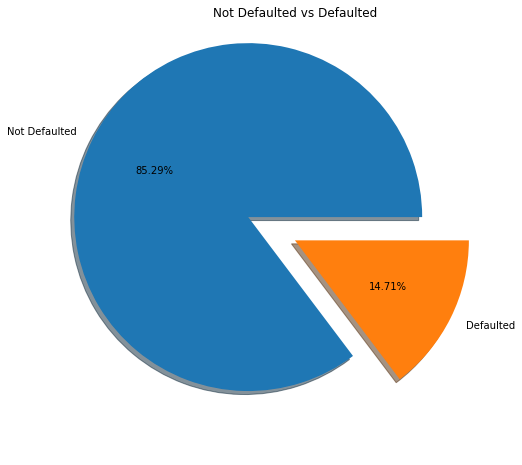

In [22]:
%matplotlib inline

# Showing the distribution of our target variable
plt.figure(figsize = (8,8))
plt.pie(
    x = df['LOAN_WAS_PAID_BACK'].value_counts(),
    labels = ['Not Defaulted','Defaulted'],
    autopct = '%1.2f%%',
    shadow = True,
    explode = (0.3,0)
)
plt.title('Not Defaulted vs Defaulted')
plt.show();

The chart shows that we are facing and imbalanced problem, which might need further processing later on during modelling

## 7.1. Distribution of age

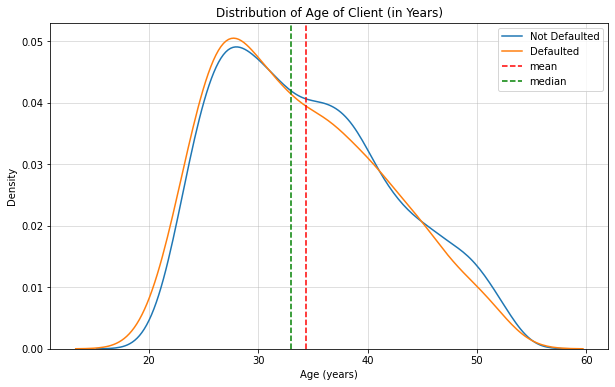

In [23]:
plt.figure(figsize=(10,6))
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 1, 'AGE'] , label = 'Not Defaulted')
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 0, 'AGE'] ,  label = 'Defaulted')
plt.axvline(df.AGE.mean(), 0, 1, label = 'mean', color = 'r', ls = '--')
plt.axvline(df.AGE.median(), 0, 1, label = 'median', color = 'g', ls = '--')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Age of Client (in Years)');

**What we discover**

We can see some pattern where customer below the median age are more likely to default. While older customer tend to pay back their loan more. However we can try binning the age feature and see how it corellated with our target variable.

### 7.1.1. binning age

In [24]:
# binning age into 5 categories
df['AgeBand'] = pd.cut(df['AGE'], 5, precision = 0)
df[['AgeBand', 'LOAN_WAS_PAID_BACK']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,LOAN_WAS_PAID_BACK
0,"(20.0, 27.0]",0.838475
1,"(27.0, 34.0]",0.845005
2,"(34.0, 40.0]",0.862837
3,"(40.0, 47.0]",0.851406
4,"(47.0, 54.0]",0.890351


By binning the age into 5 groups we have validated our previous assumption, although there is a slight variation in the age group between 40 and 47. We will therefore proceed with binning age into a categorical feature

In [25]:
# replace AGE with ordinals

df.loc[ df['AGE'] <= 20, 'AGE'] = 0
df.loc[(df['AGE'] > 20) & (df['AGE'] <= 34), 'AGE'] = 1
df.loc[(df['AGE'] > 34) & (df['AGE'] <= 40), 'AGE'] = 2
df.loc[(df['AGE'] > 40) & (df['AGE'] <= 47), 'AGE'] = 3
df.loc[ df['AGE'] > 47, 'AGE'] = 4
df.head()

,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,LOAN_WAS_PAID_BACK,AgeBand
1749,3,9000000.0,Male,High School,Credit card,No,Yes,3.0,2.0,1,"(40.0, 47.0]"
3488,1,12000000.0,Female,Bachelor Degree,Working Capital,Yes,Yes,1.0,3.0,1,"(34.0, 40.0]"
89,1,15000000.0,Female,Bachelor Degree,Holiday,No,Yes,5.0,0.0,1,"(20.0, 27.0]"
1035,1,5000000.0,Male,Bachelor Degree,Credit card,No,Yes,1.0,0.0,1,"(20.0, 27.0]"
386,3,10000000.0,Female,Bachelor Degree,Working Capital,No,Yes,3.0,1.0,1,"(40.0, 47.0]"


In [26]:
# remove ageband
df = df.drop(['AgeBand'], axis=1)
df.head()

,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,LOAN_WAS_PAID_BACK
1749,3,9000000.0,Male,High School,Credit card,No,Yes,3.0,2.0,1
3488,1,12000000.0,Female,Bachelor Degree,Working Capital,Yes,Yes,1.0,3.0,1
89,1,15000000.0,Female,Bachelor Degree,Holiday,No,Yes,5.0,0.0,1
1035,1,5000000.0,Male,Bachelor Degree,Credit card,No,Yes,1.0,0.0,1
386,3,10000000.0,Female,Bachelor Degree,Working Capital,No,Yes,3.0,1.0,1


## 7.2. Distribution of INCOME variable

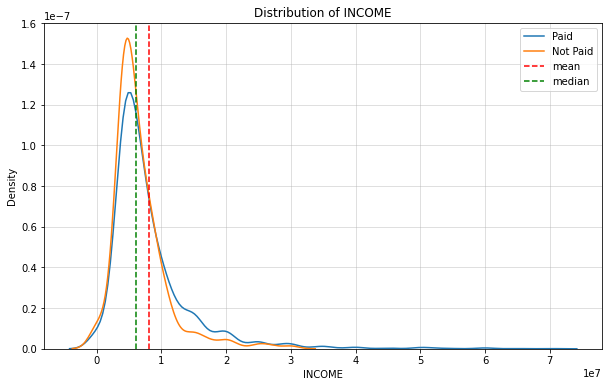

In [27]:
plt.figure(figsize=(10,6))
plt.grid(True, alpha=0.5)
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 1, 'INCOME'] , label = 'Paid')
sns.kdeplot(df.loc[df['LOAN_WAS_PAID_BACK'] == 0, 'INCOME'] ,  label = 'Not Paid')
plt.axvline(df.INCOME.mean(), 0, 1, label = 'mean', color = 'r', ls = '--')
plt.axvline(df.INCOME.median(), 0, 1, label = 'median', color = 'g', ls = '--')
plt.xlabel('INCOME')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of INCOME');

**What we discover**

Income feature are quite skewed with outliers. However we can see that customer with lower income level tend to not paying back their loan, compare to much more well off customer with higher income. <br>
We will try and see how the target variable is distributed if we bin our INCOME feature

### 7.2.1. binning income

In [28]:
df['INCOMEBAND'] = pd.qcut(df['INCOME'], 6)
df[['INCOMEBAND', 'LOAN_WAS_PAID_BACK']].groupby(['INCOMEBAND'], as_index=False).mean().sort_values(by='INCOMEBAND', ascending=True)

,INCOMEBAND,LOAN_WAS_PAID_BACK
0,"(-0.001, 4000000.0]",0.820200
1,"(4000000.0, 5000000.0]",0.833729
2,"(5000000.0, 6000000.0]",0.840426
3,"(6000000.0, 8000000.0]",0.855491
4,"(8000000.0, 11000000.0]",0.859944
5,"(11000000.0, 70000000.0]",0.926829


We can see a somewhat linear pattern where lower income customer are less likely to pay back their loan. We will then bin this INCOME variable according to the above category

In [29]:
# replace INCOME with ordinals

df.loc[ df['INCOME'] <= 4e6, 'INCOME'] = 0
df.loc[(df['INCOME'] > 4e6) & (df['INCOME'] <= 5e6), 'INCOME'] = 1
df.loc[(df['INCOME'] > 5e6) & (df['INCOME'] <= 6e6), 'INCOME'] = 2
df.loc[(df['INCOME'] > 6e6) & (df['INCOME'] <= 8e6), 'INCOME'] = 3
df.loc[(df['INCOME'] > 8e6) & (df['INCOME'] <= 11e6), 'INCOME'] = 4
df.loc[ df['INCOME'] > 11e6, 'INCOME'] = 5
df.head()

,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,LOAN_WAS_PAID_BACK,INCOMEBAND
1749,3,4.0,Male,High School,Credit card,No,Yes,3.0,2.0,1,"(8000000.0, 11000000.0]"
3488,1,5.0,Female,Bachelor Degree,Working Capital,Yes,Yes,1.0,3.0,1,"(11000000.0, 70000000.0]"
89,1,5.0,Female,Bachelor Degree,Holiday,No,Yes,5.0,0.0,1,"(11000000.0, 70000000.0]"
1035,1,1.0,Male,Bachelor Degree,Credit card,No,Yes,1.0,0.0,1,"(4000000.0, 5000000.0]"
386,3,4.0,Female,Bachelor Degree,Working Capital,No,Yes,3.0,1.0,1,"(8000000.0, 11000000.0]"


In [30]:
# remove INCOMEBAND
df = df.drop(['INCOMEBAND'], axis=1)
df.head()

,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,LOAN_WAS_PAID_BACK
1749,3,4.0,Male,High School,Credit card,No,Yes,3.0,2.0,1
3488,1,5.0,Female,Bachelor Degree,Working Capital,Yes,Yes,1.0,3.0,1
89,1,5.0,Female,Bachelor Degree,Holiday,No,Yes,5.0,0.0,1
1035,1,1.0,Male,Bachelor Degree,Credit card,No,Yes,1.0,0.0,1
386,3,4.0,Female,Bachelor Degree,Working Capital,No,Yes,3.0,1.0,1


## 7.3. Visualizing GENDER feature 

Male      1714
Female    1487
Name: GENDER, dtype: int64


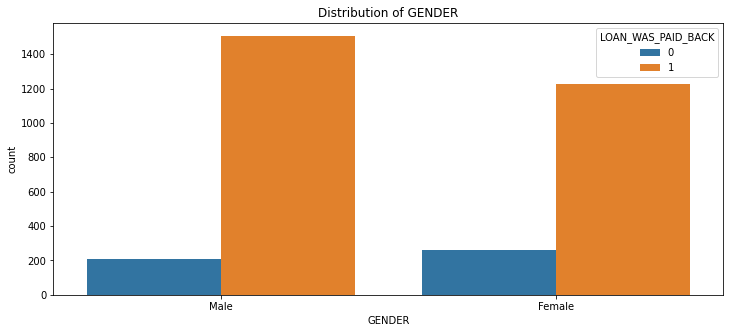

In [31]:
# visualize gender distribution related to target
print(df.GENDER.value_counts())

plt.figure(figsize=(12,5))
ax = sns.countplot(hue="LOAN_WAS_PAID_BACK", x="GENDER", data=df)
plt.title("Distribution of GENDER")
plt.show()

Based on the visualisation we can see while Female make up smaller proportion of customer in the sample, number of defaulted female is higher than their counterpart. Therefore we are going to include gender as a feature

## 7.4. Visualizing EDUCATION

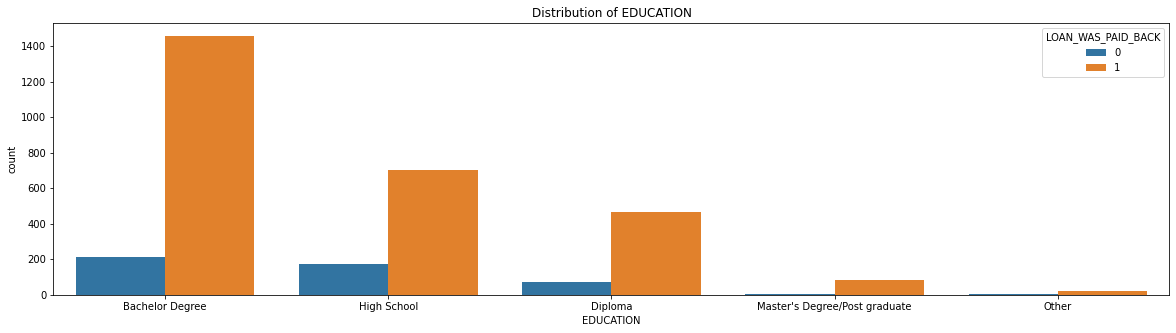

In [32]:
plt.figure(figsize=(20,5))
ax = sns.countplot(hue="LOAN_WAS_PAID_BACK",
                   x="EDUCATION", 
                   data=df, 
                  order = df["EDUCATION"].value_counts().index)
plt.title("Distribution of EDUCATION")
plt.show()

### 7.4.1. Let's see how education and gender corelate with each other 

In [33]:
edu_gender_1 = df.loc[df['LOAN_WAS_PAID_BACK'] == 1,
                      ['EDUCATION', 'GENDER', 'LOAN_WAS_PAID_BACK']]\
.groupby('EDUCATION')['GENDER'].value_counts(normalize=True).unstack().reset_index()

edu_gender_0 = df.loc[df['LOAN_WAS_PAID_BACK'] == 0,
                      ['EDUCATION', 'GENDER', 'LOAN_WAS_PAID_BACK']]\
.groupby('EDUCATION')['GENDER'].value_counts(normalize=True).unstack().reset_index()

In [34]:
edu_0 = pd.melt(edu_gender_0, id_vars = "EDUCATION")
edu_1 = pd.melt(edu_gender_1, id_vars = "EDUCATION")

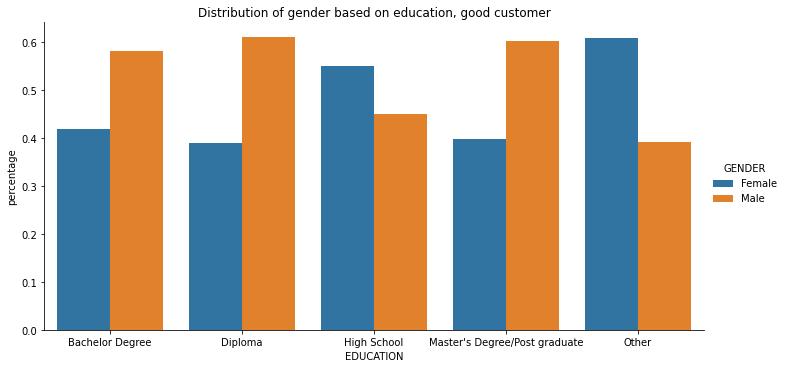

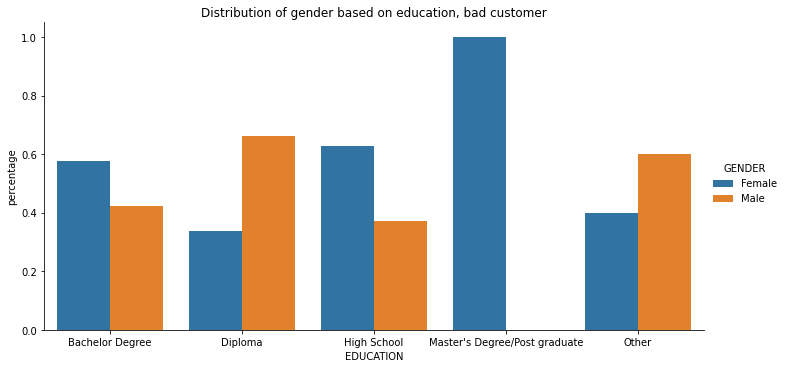

In [35]:
sns.catplot(x = 'EDUCATION', y='value', 
            hue = 'GENDER',data=edu_1, 
            kind='bar',  height=5, aspect=2)
plt.title("Distribution of gender based on education, good customer")
plt.ylabel("percentage")
plt.show()

sns.catplot(x = 'EDUCATION', y='value', 
            hue = 'GENDER',data=edu_0, 
            kind='bar',  height=5, aspect=2)
plt.title("Distribution of gender based on education, bad customer")
plt.ylabel("percentage")
plt.show()

**What we discover**

- Male with higher degree of education are more likely to pay bay their loan and become good customer 
- Proportionaly there are more female with high school education level in both good and bad customer 
- Surprisingly, all male customer with a post graduate degree are good customer and paid back all their loan
- While at the same time, we can see that except in diploma and other education level, female applicants tend to default on their loan accross all education level

**Decision**

We are also going to include EDUCATION as a feature in our model

## 7.5. LOAN_PURPOSE 

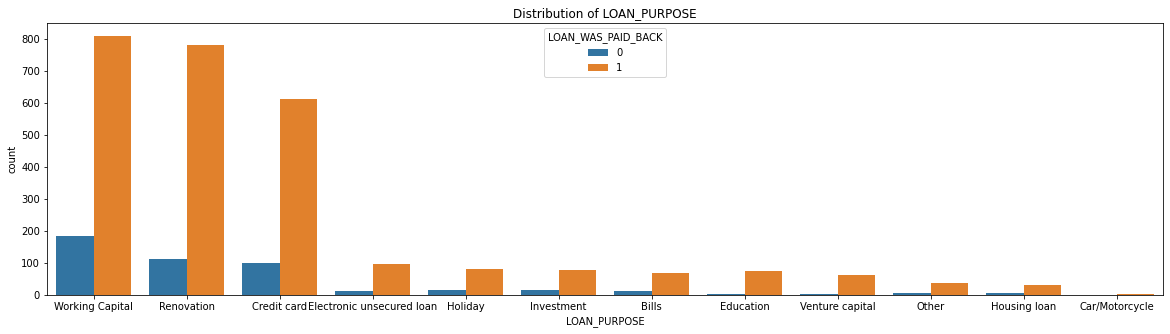

In [36]:
plt.figure(figsize=(20,5))
ax = sns.countplot(hue="LOAN_WAS_PAID_BACK",
                   x="LOAN_PURPOSE", 
                   data=df, 
                  order = df["LOAN_PURPOSE"].value_counts().index)
plt.title("Distribution of LOAN_PURPOSE")
plt.show()

**What we discover**

- Most of the customer apply for productive loan to help their business, as the top 2 loans are working capital and renovation
- Consumptive loan are next category, in which credit card, unsecured and loan for holiday purpose are next in terms of number of applicants
- We can also see there is a trend , in which top 3 loan category has the highest amount of default customer by counts, which might be valuable for the model

**Decision**

We are also going to include LOAN_PURPOSE as a feature in our model

## 7.6. HAS_INCOME_VERIFICATION

In [37]:
# let's see how income verification corelate with income and target 
income_1 = df.loc[df['LOAN_WAS_PAID_BACK'] == 1,
                      ['INCOME', 'HAS_INCOME_VERIFICATION', 'LOAN_WAS_PAID_BACK']]\
.groupby('INCOME')['HAS_INCOME_VERIFICATION'].value_counts(normalize=True).unstack().reset_index()

income_0 = df.loc[df['LOAN_WAS_PAID_BACK'] == 0,
                      ['INCOME', 'HAS_INCOME_VERIFICATION', 'LOAN_WAS_PAID_BACK']]\
.groupby('INCOME')['HAS_INCOME_VERIFICATION'].value_counts(normalize=True).unstack().reset_index()

income_1_df = pd.melt(income_1, id_vars = "INCOME")
income_0_df = pd.melt(income_0, id_vars = "INCOME")

In [38]:
income_1_df

,INCOME,HAS_INCOME_VERIFICATION,value
0,0.0,No,0.033829
1,1.0,No,0.002849
2,2.0,No,0.025316
3,3.0,No,0.020270
4,4.0,No,0.009772
5,5.0,No,0.006073
6,0.0,Yes,0.966171
7,1.0,Yes,0.997151
8,2.0,Yes,0.974684
9,3.0,Yes,0.979730


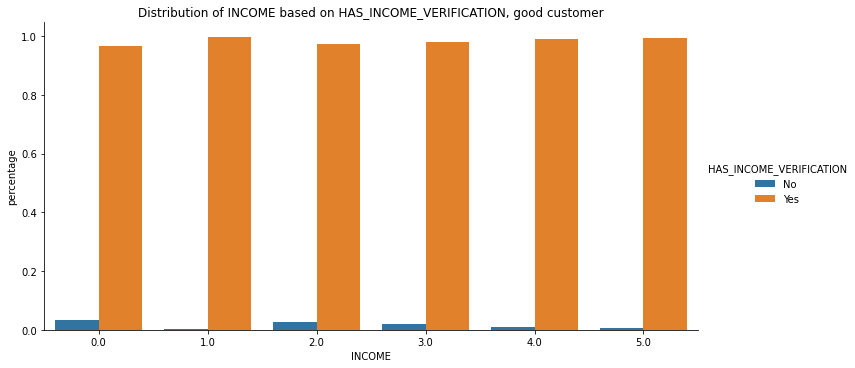

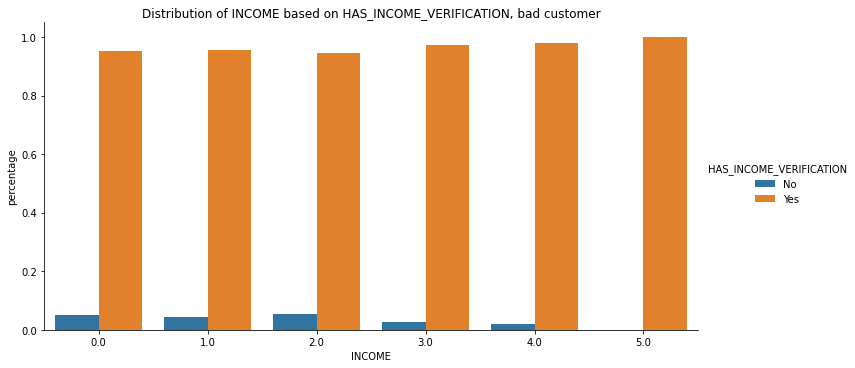

In [39]:
sns.catplot(x = 'INCOME', y='value', 
            hue = 'HAS_INCOME_VERIFICATION',data=income_1_df, 
            kind='bar',  height=5, aspect=2)
plt.title("Distribution of INCOME based on HAS_INCOME_VERIFICATION, good customer")
plt.ylabel("percentage")
plt.show()

sns.catplot(x = 'INCOME', y='value', 
            hue = 'HAS_INCOME_VERIFICATION',data=income_0_df, 
            kind='bar',  height=5, aspect=2)
plt.title("Distribution of INCOME based on HAS_INCOME_VERIFICATION, bad customer")
plt.ylabel("percentage")
plt.show()

We can see that customer without income verification are more likely to default on their payment, especially in the lower income region (group 0 - 2)

## 7.7. Distribution of HAS_APPLIED BEFORE feature

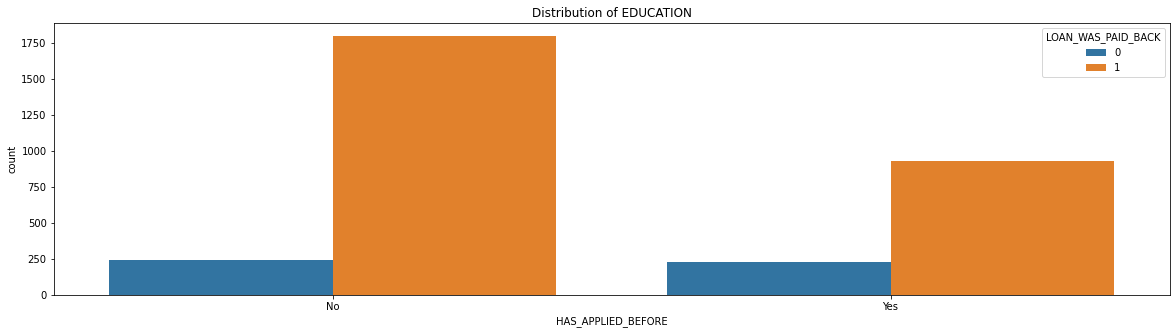

In [40]:
plt.figure(figsize=(20,5))
ax = sns.countplot(hue="LOAN_WAS_PAID_BACK",
                   x="HAS_APPLIED_BEFORE", 
                   data=df, 
                  order = df["HAS_APPLIED_BEFORE"].value_counts().index)
plt.title("Distribution of EDUCATION")
plt.show()

# 8. Feature Engineering and Selection

Based on previous parts, we are going to make 2 model that distinguished by have or doesn't have bureau data and we will use features:
- AGE (binned)
- INCOME (binned)
- GENDER
- EDUCATION
- LOAN_PURPOSE
- HAS_APPLIED_BEFORE
- HAS INCOME VERIFICATION
- Bureau data ("LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS")

In [41]:
def binning_features(df):
    #binning Age
    df.loc[ df['AGE'] <= 20, 'AGE'] = 0
    df.loc[(df['AGE'] > 20) & (df['AGE'] <= 34), 'AGE'] = 1
    df.loc[(df['AGE'] > 34) & (df['AGE'] <= 40), 'AGE'] = 2
    df.loc[(df['AGE'] > 40) & (df['AGE'] <= 47), 'AGE'] = 3
    df.loc[ df['AGE'] > 47, 'AGE'] = 4
    
    #income
    df.loc[ df['INCOME'] <= 4e6, 'INCOME'] = 0
    df.loc[(df['INCOME'] > 4e6) & (df['INCOME'] <= 5e6), 'INCOME'] = 1
    df.loc[(df['INCOME'] > 5e6) & (df['INCOME'] <= 6e6), 'INCOME'] = 2
    df.loc[(df['INCOME'] > 6e6) & (df['INCOME'] <= 8e6), 'INCOME'] = 3
    df.loc[(df['INCOME'] > 8e6) & (df['INCOME'] <= 11e6), 'INCOME'] = 4
    df.loc[ df['INCOME'] > 11e6, 'INCOME'] = 5

    return df

In [42]:
def one_hot_encoder(x_cat):
    df = x_cat.copy()
    index = x_cat.index
    col = x_cat.columns
    
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoder.fit(x_cat)

    encoded = encoder.transform(x_cat)
    feat_names = encoder.get_feature_names(col)
    encoded = pd.DataFrame(encoded)
    encoded.index = index
    encoded.columns = feat_names
    return encoded

In [43]:
#compile all engineering
def feature_engineering(df):
    TARGET = "LOAN_WAS_PAID_BACK"
    #drop some features
    df = df.drop(["customer_id", "APPLICATION_RECEIVE_TIME", "KNOWN_ASSETS", "Score"], axis=1)
    #dropna for Income and Loan Purpose
    df = df.dropna(subset = ['INCOME', 'LOAN_PURPOSE'])
    
    #binning
    binning_features(df)
    
    #converting categorical Features
    df['GENDER'] = df['GENDER'].map( {'Male': 1, 'Female': 0} ).astype(int)
    df['HAS_APPLIED_BEFORE'] = df['HAS_APPLIED_BEFORE'].map( {'Yes': 1, 'No': 0} ).astype(int)
    df['HAS_INCOME_VERIFICATION'] = df['HAS_INCOME_VERIFICATION'].map( {'Yes': 1, 'No': 0} ).astype(int)
    
    #one hot encoding
    df_num = df.drop(['EDUCATION','LOAN_PURPOSE'], axis=1)
    df_hot = one_hot_encoder(df[['EDUCATION','LOAN_PURPOSE']])
    df_ready = df_num.join(df_hot)
    
    #split data with or without bureau data
    df_with_bureau = df_ready.dropna(subset = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS'])
    df_without_bureau = df_ready[df_ready['LOANS_WITH_DELAYS'].isna() == True]
    df_without_bureau = df_ready.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])
    X_with_bureau = df_with_bureau.drop(columns=TARGET)
    X_without_bureau = df_without_bureau.drop(columns=TARGET)
    y_with_bureau = df_with_bureau[TARGET]
    y_without_bureau = df_without_bureau[TARGET]
    return X_with_bureau,X_without_bureau,y_with_bureau,y_without_bureau


def add_columns(df_raw, df_2,bureau='yes'):
    df_temp = df_2.copy()
    X_with_bureau,X_without_bureau,y_with_bureau,y_without_bureau = feature_engineering(df_raw)
    if bureau =='yes':
        mis_col = set(X_with_bureau.columns).difference(set(df_2.columns))
        print(mis_col)
    else:
        mis_col = set(X_without_bureau.columns).difference(set(df_2.columns))
        print(mis_col)
    if len(mis_col) > 0:
        for i in mis_col :
            df_temp.loc[:, i] = 0
    else:
        pass
    return df_temp

In [44]:
#compile all engineering
def feature_engineering_xb(df):
    TARGET = "LOAN_WAS_PAID_BACK"
    #drop some features
    df = df.drop(["customer_id", "APPLICATION_RECEIVE_TIME", "KNOWN_ASSETS", "Score"], axis=1)
    #dropna for Income and Loan Purpose
    df = df.dropna(subset = ['INCOME', 'LOAN_PURPOSE'])
    
    #binning
    binning_features(df)
    
    #converting categorical Features
    df['GENDER'] = df['GENDER'].map( {'Male': 1, 'Female': 0} ).astype(int)
    df['HAS_APPLIED_BEFORE'] = df['HAS_APPLIED_BEFORE'].map( {'Yes': 1, 'No': 0} ).astype(int)
    df['HAS_INCOME_VERIFICATION'] = df['HAS_INCOME_VERIFICATION'].map( {'Yes': 1, 'No': 0} ).astype(int)
    
    #one hot encoding
    df_num = df.drop(['EDUCATION','LOAN_PURPOSE'], axis=1)
    df_hot = one_hot_encoder(df[['EDUCATION','LOAN_PURPOSE']])
    df_ready = df_num.join(df_hot)
    df_without_bureau=df_ready #tambahan
    
    #split data with or without bureau data
    #df_with_bureau = df_ready.dropna(subset = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS'])
    #df_without_bureau = df_ready[df_ready['LOANS_WITH_DELAYS'].isna() == True]
    #df_without_bureau = df_ready.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])
    #X_with_bureau = df_with_bureau.drop(columns=TARGET)
    X_without_bureau = df_without_bureau.drop(columns=TARGET)
    #y_with_bureau = df_with_bureau[TARGET]
    y_without_bureau = df_without_bureau[TARGET]
    return X_without_bureau,y_without_bureau


def add_columns_xb(df_raw, df_2):
    df_temp = df_2.copy()
    X_without_bureau,y_without_bureau = feature_engineering_xb(df_raw)
    mis_col = set(X_without_bureau.columns).difference(set(df_2.columns))
    print(mis_col)
    if len(mis_col) > 0:
        for i in mis_col :
            df_temp.loc[:, i] = 0
    else:
        pass
    return df_temp

In [45]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


## 8.1. Train Engginering

In [46]:
df_train = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

In [47]:
df.shape

(6588, 14)

In [48]:
# This is our final feature
X_train_with_bureau, X_train_without_bureau, y_train_with_bureau, y_train_without_bureau = feature_engineering(df_train)

In [49]:
X_train_with_bureau = add_columns(df,X_train_with_bureau)
X_train_without_bureau = add_columns(df,X_train_without_bureau,bureau='no')

set()
set()


In [50]:
print(f' Data Train With Bureau has {X_train_with_bureau.shape[1]} Features')
print(f' Data Train Without Bureau has {X_train_without_bureau.shape[1]} Features')

 Data Train With Bureau has 24 Features
 Data Train Without Bureau has 22 Features


## 8.2. Validation Engginering

In [51]:
df_valid = pd.concat([x_valid, pd.DataFrame(y_valid)], axis = 1)

In [52]:
X_valid_with_bureau, X_valid_without_bureau, y_valid_with_bureau, y_valid_without_bureau = feature_engineering(df_valid)

In [53]:
X_valid_with_bureau = add_columns(df,X_valid_with_bureau)
X_valid_without_bureau = add_columns(df,X_valid_without_bureau,bureau='no')

set()
set()


In [54]:
print(f' Data Valid With Bureau has {X_valid_with_bureau.shape[1]} Features')
print(f' Data Valid Without Bureau has {X_valid_without_bureau.shape[1]} Features')

 Data Valid With Bureau has 24 Features
 Data Valid Without Bureau has 22 Features


## 8.3. Test Engginering

In [55]:
df_test = pd.concat([x_test, pd.DataFrame(y_test)], axis = 1)

In [56]:
X_test_with_bureau, X_test_without_bureau, y_test_with_bureau, y_test_without_bureau = feature_engineering(df_test)

In [57]:
X_test_with_bureau = add_columns(df,X_test_with_bureau)
X_test_without_bureau = add_columns(df,X_test_without_bureau,bureau='no')

{'LOAN_PURPOSE_Car/Motorcycle'}
{'LOAN_PURPOSE_Car/Motorcycle'}


In [58]:
print(f' Data Test With Bureau has {X_test_with_bureau.shape[1]} Features')
print(f' Data Test Without Bureau has {X_test_without_bureau.shape[1]} Features')

 Data Test With Bureau has 24 Features
 Data Test Without Bureau has 22 Features


# 9. ML Training

## Without Bureau Data (SMOTE)

Before we train we want To tackle the imbalanced data problem

In [59]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

oversample = SMOTE()
X_train_without_bureau, y_train_without_bureau = oversample.fit_resample(X_train_without_bureau, y_train_without_bureau)
X_train_without_bureau

,AGE,INCOME,GENDER,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,EDUCATION_Bachelor Degree,EDUCATION_Diploma,EDUCATION_High School,EDUCATION_Master's Degree/Post graduate,EDUCATION_Other,...,LOAN_PURPOSE_Credit card,LOAN_PURPOSE_Education,LOAN_PURPOSE_Electronic unsecured loan,LOAN_PURPOSE_Holiday,LOAN_PURPOSE_Housing loan,LOAN_PURPOSE_Investment,LOAN_PURPOSE_Other,LOAN_PURPOSE_Renovation,LOAN_PURPOSE_Venture capital,LOAN_PURPOSE_Working Capital
0,3,4.000000,1,0,1,0.0,0.0,1.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,5.000000,0,1,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,1,5.000000,0,0,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,1,1.000000,1,0,1,1.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,3,4.000000,0,0,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,1,0.982842,1,1,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
5456,1,2.000000,1,1,1,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
5457,1,3.974003,0,0,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
5458,3,5.000000,0,0,1,1.0,0.0,0.0,0.0,0.0,...,0.197242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.802758


In [60]:
#check balance of data
y_train_without_bureau.value_counts()

1    2730
0    2730
Name: LOAN_WAS_PAID_BACK, dtype: int64

In [61]:
X_train_without_bureau.shape

(5460, 22)

In [62]:
#we try on valid data
X_valid_without_bureau_rs, y_valid_without_bureau_rs = oversample.fit_resample(X_valid_without_bureau, y_valid_without_bureau)
X_valid_without_bureau_rs

,AGE,INCOME,GENDER,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,EDUCATION_Bachelor Degree,EDUCATION_Diploma,EDUCATION_High School,EDUCATION_Master's Degree/Post graduate,EDUCATION_Other,...,LOAN_PURPOSE_Credit card,LOAN_PURPOSE_Education,LOAN_PURPOSE_Electronic unsecured loan,LOAN_PURPOSE_Holiday,LOAN_PURPOSE_Housing loan,LOAN_PURPOSE_Investment,LOAN_PURPOSE_Other,LOAN_PURPOSE_Renovation,LOAN_PURPOSE_Venture capital,LOAN_PURPOSE_Working Capital
0,2,2.0,1,0,0,1.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,0.0,1,0,1,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
2,1,0.0,1,1,1,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,1,0.0,1,0,1,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,2,3.0,0,0,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,1,0.0,1,1,1,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
2336,1,1.0,1,1,1,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2337,2,2.0,0,0,1,0.0,0.0,1.0,0.0,0.0,...,0.714875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285125
2338,1,0.0,0,0,1,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000


In [63]:
#check balance of data
y_valid_without_bureau.value_counts()

1    1170
0     201
Name: LOAN_WAS_PAID_BACK, dtype: int64

In [64]:
# Changing everything to float and replacing infinities
for c in X_train_without_bureau.columns:
  X_train_without_bureau[c] = X_train_without_bureau[c].astype(np.float64)
X_train_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [65]:
# Changing everything to float and replacing infinities
for c in X_valid_without_bureau.columns:
  X_valid_without_bureau[c] = X_valid_without_bureau[c].astype(np.float64)
X_valid_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [66]:
# Changing everything to float and replacing infinities
for c in X_test_without_bureau.columns:
  X_test_without_bureau[c] = X_test_without_bureau[c].astype(np.float64)
X_test_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [67]:
X_train_without_bureau.isnull().sum()

AGE                                        0
INCOME                                     0
GENDER                                     0
HAS_APPLIED_BEFORE                         0
HAS_INCOME_VERIFICATION                    0
EDUCATION_Bachelor Degree                  0
EDUCATION_Diploma                          0
EDUCATION_High School                      0
EDUCATION_Master's Degree/Post graduate    0
EDUCATION_Other                            0
LOAN_PURPOSE_Bills                         0
LOAN_PURPOSE_Car/Motorcycle                0
LOAN_PURPOSE_Credit card                   0
LOAN_PURPOSE_Education                     0
LOAN_PURPOSE_Electronic unsecured loan     0
LOAN_PURPOSE_Holiday                       0
LOAN_PURPOSE_Housing loan                  0
LOAN_PURPOSE_Investment                    0
LOAN_PURPOSE_Other                         0
LOAN_PURPOSE_Renovation                    0
LOAN_PURPOSE_Venture capital               0
LOAN_PURPOSE_Working Capital               0
dtype: int

In [68]:
# Fixing column names that contains [,],or < for XGBoost model
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_without_bureau.columns.values]
X_valid_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_without_bureau.columns.values]
X_test_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_without_bureau.columns.values]

In [69]:
# Check the baseline model
def baseline_model(X_train,y_train):
  clf_logreg = LogisticRegression().fit(X_train,y_train)
  clf_rf = RandomForestClassifier().fit(X_train,y_train)
  clf_tree = DecisionTreeClassifier().fit(X_train,y_train)
  clf_knn = KNeighborsClassifier().fit(X_train,y_train)
  clf_lgbm = LGBMClassifier().fit(X_train,y_train)
  clf_xgb = xgb.XGBClassifier().fit(X_train,y_train)

  gini_logreg = (2*(roc_auc_score(y_train, clf_logreg.predict_proba(X_train)[:, 1])))-1
  gini_rf = (2*(roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:, 1])))-1
  gini_tree = (2*(roc_auc_score(y_train, clf_tree.predict_proba(X_train)[:, 1])))-1
  gini_knn = (2*(roc_auc_score(y_train, clf_knn.predict_proba(X_train)[:, 1])))-1
  gini_lgbm = (2*(roc_auc_score(y_train, clf_lgbm.predict_proba(X_train)[:, 1])))-1
  gini_xgb = (2*(roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1])))-1

  print("Gini Performance Evaluation\n")
  print(f"Logistic Regression Gini : {gini_logreg}")
  print(f"Random Forest Gini       : {gini_rf}")
  print(f"Decision Tree Gini       : {gini_tree}")
  print(f"KNN Classifier Gini      : {gini_knn}")
  print(f"LGBM Gini                : {gini_lgbm}")
  print(f"XGBoost Gini             : {gini_xgb}")

  return clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb
 
clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb = baseline_model(X_train_without_bureau,y_train_without_bureau)

[19:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Gini Performance Evaluation

Logistic Regression Gini : 0.36413973084302764
Random Forest Gini       : 0.872216050128138
Decision Tree Gini       : 0.8780392867206055
KNN Classifier Gini      : 0.7237075500811767
LGBM Gini                : 0.8213137168082223
XGBoost Gini             : 0.8293143608528224


Hyperparameter tuning on best baseline model
We will be using Decision Tree since it has the highest gini score.

#### Hyperparameter tuning on best baseline model


In [70]:
%%time

clf_xgb = xgb.XGBClassifier()
clf_tree = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=420)

# Define search space
space_tree = dict()
space_rf = dict()
space_xgb = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
    'fs__k': [10],
  }
]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #RF
max_depth.append(None) #RF
space_rf['max_depth'] = max_depth # RF
space_rf['min_samples_split'] = [2, 5, 10] # RF
space_rf['min_samples_leaf'] = [1, 2, 4] # RF

space_tree['max_depth'] = [2, 3, 5, 10, 20] #DT
space_tree['min_samples_leaf'] = [5, 10, 20, 50, 100] #DT
space_tree['criterion'] = ["gini", "entropy"] #DT

# Define search
search_tree = RandomizedSearchCV(clf_tree, space_tree, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_rf = RandomizedSearchCV(clf_rf, space_rf, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_xgb = RandomizedSearchCV(clf_xgb, space_xgb, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)

# Execute search
result_tree = search_tree.fit(X_train_without_bureau,y_train_without_bureau)
result_rf = search_rf.fit(X_train_without_bureau,y_train_without_bureau)
result_xgb = search_xgb.fit(X_train_without_bureau,y_train_without_bureau)

# Summarize result
print('Best Score tree: %s' % ((result_tree.best_score_ * 2) - 1))
print('Best Hyperparameters: %s' % result_tree.best_params_)

print('Best Score rf: %s' % ((result_rf.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_rf.best_params_)

print('Best Score xgb: %s' % ((result_xgb.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_xgb.best_params_)

[19:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__n_estimators", "fs__k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score tree: 0.6788679574393861
Best Hyperparameters: {'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
Best Score rf: 0.741340954527768
Best Hyperparameters

#### Evaluate on validation data

In [71]:
dt_valid = DecisionTreeClassifier(
    min_samples_leaf = 5, 
    max_depth = 20, 
    criterion = 'entropy').fit(X_train_without_bureau,y_train_without_bureau)

rf_valid = RandomForestClassifier(
    min_samples_split = 5, 
    min_samples_leaf = 1, 
    max_depth = 60).fit(X_train_without_bureau,y_train_without_bureau)

xgb_valid = xgb.XGBClassifier(
    fs__k= 10, 
    n_estimators= 200, 
    max_depth= 8, 
    learning_rate= 0.3, 
    gamma= 0.0, 
    colsample_bytree= 0.1,
    verbosity = 0).fit(X_train_without_bureau,y_train_without_bureau)

def gini_value(x, y, model):
    return (2*(roc_auc_score(y, model.predict_proba(x)[:, 1])))-1

print("GINI validation data for Decision Tree :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, dt_valid))
print("GINI validation data for Random Forest :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, rf_valid))
print("GINI validation data for XGBOOST :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, xgb_valid))

GINI validation data for Decision Tree : 0.10670578730280234
GINI validation data for Random Forest : 0.08697537951269307
GINI validation data for XGBOOST : 0.19019432750776044


In [72]:
from sklearn.metrics import classification_report

y_pred_train = xgb_valid.predict(X_train_without_bureau)

print(classification_report(y_train_without_bureau, y_pred_train))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      2730
           1       0.72      0.80      0.76      2730

    accuracy                           0.74      5460
   macro avg       0.75      0.74      0.74      5460
weighted avg       0.75      0.74      0.74      5460



In [73]:
#ini valid yang di Resampled
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_without_bureau_rs)

print(classification_report(y_valid_without_bureau_rs, y_pred_valid))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1170
           1       0.73      0.78      0.76      1170

    accuracy                           0.75      2340
   macro avg       0.75      0.75      0.75      2340
weighted avg       0.75      0.75      0.75      2340



In [74]:
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_without_bureau)

print(classification_report(y_valid_without_bureau, y_pred_valid))

              precision    recall  f1-score   support

           0       0.19      0.30      0.23       201
           1       0.87      0.78      0.82      1170

    accuracy                           0.71      1371
   macro avg       0.53      0.54      0.53      1371
weighted avg       0.77      0.71      0.74      1371



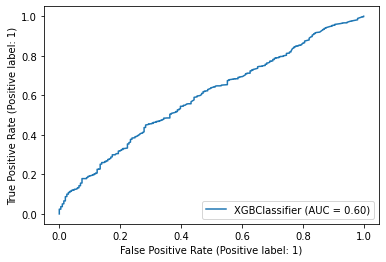

In [75]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_valid,X_valid_without_bureau,y_valid_without_bureau)
plt.show()

In [76]:
y_pred_test_without_bureau = xgb_valid.predict(X_test_without_bureau)
print(classification_report(y_test_without_bureau, y_pred_test_without_bureau))

              precision    recall  f1-score   support

           0       0.15      0.07      0.10       289
           1       0.85      0.93      0.89      1676

    accuracy                           0.81      1965
   macro avg       0.50      0.50      0.49      1965
weighted avg       0.75      0.81      0.77      1965



In [77]:
print(f"Final DecisionTree Gini Score (on test Set)            : {(2*(roc_auc_score(y_test_without_bureau, xgb_valid.predict_proba(X_test_without_bureau)[:, 1])))-1} ")

Final DecisionTree Gini Score (on test Set)            : -0.046518733844794324 


#### Evaluate with all data

##### Without bureau data

In [78]:
# get all data without bureau
df_all_xb = df[df['LOANS_WITH_DELAYS'].isna() == True]
df_all_xb = df_all_xb.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all_xb.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
1,36500,29,14000000.0,Female,Bachelor Degree,Renovation,19:30:00,Yes,Yes,0,NaN,0.86
2,36505,36,21000000.0,Female,Bachelor Degree,Renovation,06:12:00,No,Yes,1,NaN,0.83
3,36510,44,5000000.0,Male,Bachelor Degree,Investment,17:48:00,No,Yes,1,NaN,0.79
4,36515,34,6000000.0,Male,Bachelor Degree,Credit card,12:17:00,No,Yes,1,NaN,NaN


In [79]:
#test with all data whitout bureau
X_cek,y_cek = feature_engineering_xb(df_all_xb)
X_cek.shape

(1308, 22)

In [80]:
y_pred = xgb_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.28      0.23       202
           1       0.86      0.78      0.82      1106

    accuracy                           0.70      1308
   macro avg       0.52      0.53      0.52      1308
weighted avg       0.75      0.70      0.73      1308



##### Without all data remove bureau

In [81]:
# get all data remove bureau
df_all = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,40000000.0,0.81


In [82]:

X_cek,y_cek = feature_engineering_xb(df_all)
X_cek.shape

(6537, 22)

In [83]:
y_pred = xgb_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.33      0.26       961
           1       0.87      0.80      0.83      5576

    accuracy                           0.73      6537
   macro avg       0.54      0.56      0.55      6537
weighted avg       0.78      0.73      0.75      6537



## uji coba dengan 50:50

In [84]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


In [85]:
df_cek = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])

In [86]:
# get all data without bureau
df_1 = df[df['LOANS_WITH_DELAYS'].isna() == True]
df_1 = df_1.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])

# get all data with label 0
df_2 = df_1.loc[(df_1.LOAN_WAS_PAID_BACK == 0)]

# get all labeled 1 data with the same number of row as label 0 data
df_3 = df_1.loc[df_1.LOAN_WAS_PAID_BACK == 1, :].sample(n = df_2.shape[0])
df_final = pd.concat([df_2, df_3], ignore_index=True)
df_final.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36500,29,14000000.0,Female,Bachelor Degree,Renovation,19:30:00,Yes,Yes,0,NaN,0.86
1,36570,23,6000000.0,Male,Bachelor Degree,Renovation,23:39:00,Yes,No,0,NaN,0.84
2,36590,31,8000000.0,Male,Bachelor Degree,Renovation,09:22:00,Yes,Yes,0,NaN,0.85
3,36600,42,6000000.0,Male,Bachelor Degree,Working Capital,11:40:00,No,Yes,0,NaN,NaN
4,36610,47,8000000.0,Female,High School,Credit card,00:24:00,No,Yes,0,NaN,0.81


In [87]:
df_final.LOAN_WAS_PAID_BACK.value_counts()

0    202
1    202
Name: LOAN_WAS_PAID_BACK, dtype: int64

In [88]:
# do the splitting
TARGET = "LOAN_WAS_PAID_BACK"
TEST_SIZE = 0.3

output_df, input_df = split_input_output(
                            df_final,
                            TARGET, save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                                    output_df,
                                                                   True,
                                                                   TEST_SIZE)

In [89]:
# check if stratify is correct
print(y_train.value_counts())
print("-------------------------------------")
print(y_valid.value_counts())
print("-------------------------------------")
print(y_test.value_counts())

1    99
0    98
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
0    43
1    42
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
0    61
1    61
Name: LOAN_WAS_PAID_BACK, dtype: int64


In [90]:
# check if stratify is correct
print(y_train.value_counts(normalize = True))
print("-------------------------------------")
print(y_valid.value_counts(normalize = True))
print("-------------------------------------")
print(y_test.value_counts(normalize = True))

1    0.502538
0    0.497462
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
0    0.505882
1    0.494118
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
0    0.5
1    0.5
Name: LOAN_WAS_PAID_BACK, dtype: float64


### Feature engineering

#### train

In [91]:
df_train = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

In [92]:
# This is our final feature
X_train_without_bureau,y_train_without_bureau = feature_engineering_xb(df_train)

In [93]:
X_train_without_bureau = add_columns_xb(df_cek,X_train_without_bureau)

{'LOAN_PURPOSE_Other', 'LOAN_PURPOSE_Car/Motorcycle', 'LOAN_PURPOSE_Housing loan'}


In [94]:
print(f' Data Train Without Bureau has {X_train_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 22 Features


#### Valid

In [95]:
df_valid = pd.concat([x_valid, pd.DataFrame(y_valid)], axis = 1)

In [96]:
# This is our final feature
X_valid_without_bureau,y_valid_without_bureau = feature_engineering_xb(df_valid)

In [97]:
X_valid_without_bureau = add_columns_xb(df_cek,X_valid_without_bureau)

{'LOAN_PURPOSE_Bills', 'LOAN_PURPOSE_Car/Motorcycle', 'LOAN_PURPOSE_Venture capital'}


In [98]:
print(f' Data Train Without Bureau has {X_valid_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 22 Features


#### Test

In [99]:
df_test = pd.concat([x_test, pd.DataFrame(y_test)], axis = 1)

In [100]:
# This is our final feature
X_test_without_bureau,y_test_without_bureau = feature_engineering_xb(df_test)

In [101]:
X_test_without_bureau = add_columns_xb(df_cek,X_test_without_bureau)

{'EDUCATION_Other', 'LOAN_PURPOSE_Car/Motorcycle'}


In [102]:
print(f' Data Train Without Bureau has {X_test_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 22 Features


In [103]:
# Changing everything to float and replacing infinities
for c in X_train_without_bureau.columns:
  X_train_without_bureau[c] = X_train_without_bureau[c].astype(np.float64)
X_train_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [104]:
# Changing everything to float and replacing infinities
for c in X_valid_without_bureau.columns:
  X_valid_without_bureau[c] = X_valid_without_bureau[c].astype(np.float64)
X_valid_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [105]:
# Changing everything to float and replacing infinities
for c in X_test_without_bureau.columns:
  X_test_without_bureau[c] = X_test_without_bureau[c].astype(np.float64)
X_test_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [106]:
X_train_without_bureau.isnull().sum()

AGE                                        0
INCOME                                     0
GENDER                                     0
HAS_APPLIED_BEFORE                         0
HAS_INCOME_VERIFICATION                    0
EDUCATION_Bachelor Degree                  0
EDUCATION_Diploma                          0
EDUCATION_High School                      0
EDUCATION_Master's Degree/Post graduate    0
EDUCATION_Other                            0
LOAN_PURPOSE_Bills                         0
LOAN_PURPOSE_Credit card                   0
LOAN_PURPOSE_Education                     0
LOAN_PURPOSE_Electronic unsecured loan     0
LOAN_PURPOSE_Holiday                       0
LOAN_PURPOSE_Investment                    0
LOAN_PURPOSE_Renovation                    0
LOAN_PURPOSE_Venture capital               0
LOAN_PURPOSE_Working Capital               0
LOAN_PURPOSE_Other                         0
LOAN_PURPOSE_Car/Motorcycle                0
LOAN_PURPOSE_Housing loan                  0
dtype: int

In [107]:
# Fixing column names that contains [,],or < for XGBoost model
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_without_bureau.columns.values]
X_valid_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_without_bureau.columns.values]
X_test_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_without_bureau.columns.values]

In [108]:
# Check the baseline model
def baseline_model(X_train,y_train):
  clf_logreg = LogisticRegression().fit(X_train,y_train)
  clf_rf = RandomForestClassifier().fit(X_train,y_train)
  clf_tree = DecisionTreeClassifier().fit(X_train,y_train)
  clf_knn = KNeighborsClassifier().fit(X_train,y_train)
  clf_lgbm = LGBMClassifier().fit(X_train,y_train)
  clf_xgb = xgb.XGBClassifier().fit(X_train,y_train)

  gini_logreg = (2*(roc_auc_score(y_train, clf_logreg.predict_proba(X_train)[:, 1])))-1
  gini_rf = (2*(roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:, 1])))-1
  gini_tree = (2*(roc_auc_score(y_train, clf_tree.predict_proba(X_train)[:, 1])))-1
  gini_knn = (2*(roc_auc_score(y_train, clf_knn.predict_proba(X_train)[:, 1])))-1
  gini_lgbm = (2*(roc_auc_score(y_train, clf_lgbm.predict_proba(X_train)[:, 1])))-1
  gini_xgb = (2*(roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1])))-1

  print("Gini Performance Evaluation\n")
  print(f"Logistic Regression Gini : {gini_logreg}")
  print(f"Random Forest Gini       : {gini_rf}")
  print(f"Decision Tree Gini       : {gini_tree}")
  print(f"KNN Classifier Gini      : {gini_knn}")
  print(f"LGBM Gini                : {gini_lgbm}")
  print(f"XGBoost Gini             : {gini_xgb}")

  return clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb
 
clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb = baseline_model(X_train_without_bureau,y_train_without_bureau)

Gini Performance Evaluation

Logistic Regression Gini : 0.4922154428781822
Random Forest Gini       : 0.9847464759099516
Decision Tree Gini       : 0.9910582789816957
KNN Classifier Gini      : 0.5353460972017672
LGBM Gini                : 0.7389017462655165
XGBoost Gini             : 0.9853776562171261


Hyperparameter tuning on best baseline model
We will be using Decision Tree since it has the highest gini score.

#### Hyperparameter tuning on best baseline model


In [109]:
%%time

clf_xgb = xgb.XGBClassifier()
clf_tree = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=420)

# Define search space
space_tree = dict()
space_rf = dict()
space_xgb = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
    'fs__k': [10],
  }
]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #RF
max_depth.append(None) #RF
space_rf['max_depth'] = max_depth # RF
space_rf['min_samples_split'] = [2, 5, 10] # RF
space_rf['min_samples_leaf'] = [1, 2, 4] # RF

space_tree['max_depth'] = [2, 3, 5, 10, 20] #DT
space_tree['min_samples_leaf'] = [5, 10, 20, 50, 100] #DT
space_tree['criterion'] = ["gini", "entropy"] #DT

# Define search
search_tree = RandomizedSearchCV(clf_tree, space_tree, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_rf = RandomizedSearchCV(clf_rf, space_rf, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_xgb = RandomizedSearchCV(clf_xgb, space_xgb, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)

# Execute search
result_tree = search_tree.fit(X_train_without_bureau,y_train_without_bureau)
result_rf = search_rf.fit(X_train_without_bureau,y_train_without_bureau)
result_xgb = search_xgb.fit(X_train_without_bureau,y_train_without_bureau)

# Summarize result
print('Best Score tree: %s' % ((result_tree.best_score_ * 2) - 1))
print('Best Hyperparameters: %s' % result_tree.best_params_)

print('Best Score rf: %s' % ((result_rf.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_rf.best_params_)

print('Best Score xgb: %s' % ((result_xgb.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_xgb.best_params_)

Best Score tree: 0.32711111111111113
Best Hyperparameters: {'min_samples_leaf': 20, 'max_depth': 3, 'criterion': 'entropy'}
Best Score rf: 0.2937222222222222
Best Hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 70}
Best Score xgb: 0.14872222222222198
Best Hyperparameters: {'fs__k': 10, 'clf__n_estimators': 200, 'clf__max_depth': 8, 'clf__learning_rate': 0.3, 'clf__gamma': 0.0, 'clf__colsample_bytree': 0.1}
Wall time: 47.2 s


#### Evaluate on validation data

In [110]:
dt_valid = DecisionTreeClassifier(
    min_samples_leaf = 5, 
    max_depth = 10, 
    criterion = 'entropy').fit(X_train_without_bureau,y_train_without_bureau)

rf_valid = RandomForestClassifier(
    min_samples_split = 5, 
    min_samples_leaf = 4, 
    max_depth = 80).fit(X_train_without_bureau,y_train_without_bureau)

xgb_valid = xgb.XGBClassifier(
    fs__k= 10, 
    n_estimators= 200, 
    max_depth= 8, 
    learning_rate= 0.3, 
    gamma= 0.0, 
    colsample_bytree= 0.1,
    verbosity = 0).fit(X_train_without_bureau,y_train_without_bureau)

def gini_value(x, y, model):
    return (2*(roc_auc_score(y, model.predict_proba(x)[:, 1])))-1

print("GINI validation data for Decision Tree :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, dt_valid))
print("GINI validation data for Random Forest :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, rf_valid))
print("GINI validation data for XGBOOST :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, xgb_valid))

GINI validation data for Decision Tree : 0.10852713178294549
GINI validation data for Random Forest : 0.0897009966777409
GINI validation data for XGBOOST : 0.1705426356589148


In [111]:
from sklearn.metrics import classification_report

y_pred_train = rf_valid.predict(X_train_without_bureau)

print(classification_report(y_train_without_bureau, y_pred_train))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74        98
           1       0.73      0.75      0.74        97

    accuracy                           0.74       195
   macro avg       0.74      0.74      0.74       195
weighted avg       0.74      0.74      0.74       195



In [112]:
from sklearn.metrics import classification_report

y_pred_valid = rf_valid.predict(X_valid_without_bureau)

print(classification_report(y_valid_without_bureau, y_pred_valid))

              precision    recall  f1-score   support

           0       0.56      0.63      0.59        43
           1       0.57      0.50      0.53        42

    accuracy                           0.56        85
   macro avg       0.57      0.56      0.56        85
weighted avg       0.57      0.56      0.56        85



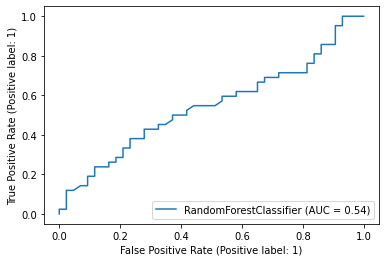

In [113]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf_valid,X_valid_without_bureau,y_valid_without_bureau)
plt.show()

In [114]:
y_pred_test_without_bureau = rf_valid.predict(X_test_without_bureau)
print(classification_report(y_test_without_bureau, y_pred_test_without_bureau))

              precision    recall  f1-score   support

           0       0.51      0.41      0.45        61
           1       0.50      0.60      0.55        60

    accuracy                           0.50       121
   macro avg       0.51      0.50      0.50       121
weighted avg       0.51      0.50      0.50       121



In [115]:
print(f"Final DecisionTree Gini Score (on test Set)            : {(2*(roc_auc_score(y_test_without_bureau, rf_valid.predict_proba(X_test_without_bureau)[:, 1])))-1} ")

Final DecisionTree Gini Score (on test Set)            : 0.05327868852459017 


#### Evaluate with all data

##### Without bureau data

In [116]:
# get all data without bureau
df_all_xb = df[df['LOANS_WITH_DELAYS'].isna() == True]
df_all_xb = df_all_xb.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all_xb.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
1,36500,29,14000000.0,Female,Bachelor Degree,Renovation,19:30:00,Yes,Yes,0,NaN,0.86
2,36505,36,21000000.0,Female,Bachelor Degree,Renovation,06:12:00,No,Yes,1,NaN,0.83
3,36510,44,5000000.0,Male,Bachelor Degree,Investment,17:48:00,No,Yes,1,NaN,0.79
4,36515,34,6000000.0,Male,Bachelor Degree,Credit card,12:17:00,No,Yes,1,NaN,NaN


In [117]:
#test with all data whitout bureau
X_cek,y_cek = feature_engineering_xb(df_all_xb)
X_cek.shape

(1308, 22)

In [118]:
y_pred = rf_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.52      0.29       202
           1       0.88      0.63      0.73      1106

    accuracy                           0.61      1308
   macro avg       0.54      0.58      0.51      1308
weighted avg       0.77      0.61      0.66      1308



##### Without all data remove bureau

In [119]:
# get all data remove bureau
df_all = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,40000000.0,0.81


In [120]:

X_cek,y_cek = feature_engineering_xb(df_all)
X_cek.shape

(6537, 22)

In [121]:
y_pred = rf_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.49      0.27       961
           1       0.88      0.62      0.73      5576

    accuracy                           0.61      6537
   macro avg       0.53      0.56      0.50      6537
weighted avg       0.78      0.61      0.66      6537



## uji coba dengan 50:50 with all data

In [122]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


In [123]:
# get all data without bureau
df_1 = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])

# get all data with label 0
df_2 = df_1.loc[(df_1.LOAN_WAS_PAID_BACK == 0)]

# get all labeled 1 data with the same number of row as label 0 data
df_3 = df_1.loc[df_1.LOAN_WAS_PAID_BACK == 1, :].sample(n = df_2.shape[0])
df_final = pd.concat([df_2, df_3], ignore_index=True)
df_final.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,40000000.0,0.81
1,36500,29,14000000.0,Female,Bachelor Degree,Renovation,19:30:00,Yes,Yes,0,NaN,0.86
2,36512,40,6000000.0,Female,Bachelor Degree,Working Capital,10:31:00,Yes,Yes,0,10000000.0,0.77
3,36526,29,6000000.0,Male,Bachelor Degree,Working Capital,10:35:00,Yes,Yes,0,10000000.0,NaN
4,36528,44,10000000.0,Female,Bachelor Degree,Credit card,07:01:00,No,Yes,0,NaN,0.77


In [124]:
df_final.LOAN_WAS_PAID_BACK.value_counts()

0    963
1    963
Name: LOAN_WAS_PAID_BACK, dtype: int64

In [125]:
# do the splitting
TARGET = "LOAN_WAS_PAID_BACK"
TEST_SIZE = 0.3

output_df, input_df = split_input_output(
                            df_final,
                            TARGET, save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                                    output_df,
                                                                   True,
                                                                   TEST_SIZE)

In [126]:
# check if stratify is correct
print(y_train.value_counts())
print("-------------------------------------")
print(y_valid.value_counts())
print("-------------------------------------")
print(y_test.value_counts())

1    472
0    471
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
0    203
1    202
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
1    289
0    289
Name: LOAN_WAS_PAID_BACK, dtype: int64


In [127]:
# check if stratify is correct
print(y_train.value_counts(normalize = True))
print("-------------------------------------")
print(y_valid.value_counts(normalize = True))
print("-------------------------------------")
print(y_test.value_counts(normalize = True))

1    0.50053
0    0.49947
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
0    0.501235
1    0.498765
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.5
0    0.5
Name: LOAN_WAS_PAID_BACK, dtype: float64


### Feature engineering

#### train

In [128]:
df_train = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

In [129]:
# This is our final feature
X_train_without_bureau,y_train_without_bureau = feature_engineering_xb(df_train)

In [130]:
X_train_without_bureau = add_columns_xb(df_final,X_train_without_bureau)

set()


In [131]:
print(f' Data Train Without Bureau has {X_train_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 21 Features


#### Valid

In [132]:
df_valid = pd.concat([x_valid, pd.DataFrame(y_valid)], axis = 1)

In [133]:
# This is our final feature
X_valid_without_bureau,y_valid_without_bureau = feature_engineering_xb(df_valid)

In [134]:
X_valid_without_bureau = add_columns_xb(df_final,X_valid_without_bureau)

set()


In [135]:
print(f' Data Train Without Bureau has {X_valid_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 21 Features


#### Test

In [136]:
df_test = pd.concat([x_test, pd.DataFrame(y_test)], axis = 1)

In [137]:
# This is our final feature
X_test_without_bureau,y_test_without_bureau = feature_engineering_xb(df_test)

In [138]:
X_test_without_bureau = add_columns_xb(df_final,X_test_without_bureau)

set()


In [139]:
print(f' Data Train Without Bureau has {X_test_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 21 Features


In [140]:
# Changing everything to float and replacing infinities
for c in X_train_without_bureau.columns:
  X_train_without_bureau[c] = X_train_without_bureau[c].astype(np.float64)
X_train_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [141]:
# Changing everything to float and replacing infinities
for c in X_valid_without_bureau.columns:
  X_valid_without_bureau[c] = X_valid_without_bureau[c].astype(np.float64)
X_valid_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [142]:
# Changing everything to float and replacing infinities
for c in X_test_without_bureau.columns:
  X_test_without_bureau[c] = X_test_without_bureau[c].astype(np.float64)
X_test_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [143]:
X_train_without_bureau.isnull().sum()

AGE                                        0
INCOME                                     0
GENDER                                     0
HAS_APPLIED_BEFORE                         0
HAS_INCOME_VERIFICATION                    0
EDUCATION_Bachelor Degree                  0
EDUCATION_Diploma                          0
EDUCATION_High School                      0
EDUCATION_Master's Degree/Post graduate    0
EDUCATION_Other                            0
LOAN_PURPOSE_Bills                         0
LOAN_PURPOSE_Credit card                   0
LOAN_PURPOSE_Education                     0
LOAN_PURPOSE_Electronic unsecured loan     0
LOAN_PURPOSE_Holiday                       0
LOAN_PURPOSE_Housing loan                  0
LOAN_PURPOSE_Investment                    0
LOAN_PURPOSE_Other                         0
LOAN_PURPOSE_Renovation                    0
LOAN_PURPOSE_Venture capital               0
LOAN_PURPOSE_Working Capital               0
dtype: int64

In [144]:
# Fixing column names that contains [,],or < for XGBoost model
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_without_bureau.columns.values]
X_valid_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_without_bureau.columns.values]
X_test_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_without_bureau.columns.values]

In [145]:
# Check the baseline model
def baseline_model(X_train,y_train):
  clf_logreg = LogisticRegression().fit(X_train,y_train)
  clf_rf = RandomForestClassifier().fit(X_train,y_train)
  clf_tree = DecisionTreeClassifier().fit(X_train,y_train)
  clf_knn = KNeighborsClassifier().fit(X_train,y_train)
  clf_lgbm = LGBMClassifier().fit(X_train,y_train)
  clf_xgb = xgb.XGBClassifier().fit(X_train,y_train)

  gini_logreg = (2*(roc_auc_score(y_train, clf_logreg.predict_proba(X_train)[:, 1])))-1
  gini_rf = (2*(roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:, 1])))-1
  gini_tree = (2*(roc_auc_score(y_train, clf_tree.predict_proba(X_train)[:, 1])))-1
  gini_knn = (2*(roc_auc_score(y_train, clf_knn.predict_proba(X_train)[:, 1])))-1
  gini_lgbm = (2*(roc_auc_score(y_train, clf_lgbm.predict_proba(X_train)[:, 1])))-1
  gini_xgb = (2*(roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1])))-1

  print("Gini Performance Evaluation\n")
  print(f"Logistic Regression Gini : {gini_logreg}")
  print(f"Random Forest Gini       : {gini_rf}")
  print(f"Decision Tree Gini       : {gini_tree}")
  print(f"KNN Classifier Gini      : {gini_knn}")
  print(f"LGBM Gini                : {gini_lgbm}")
  print(f"XGBoost Gini             : {gini_xgb}")

  return clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb
 
clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb = baseline_model(X_train_without_bureau,y_train_without_bureau)

Gini Performance Evaluation

Logistic Regression Gini : 0.3531272971331778
Random Forest Gini       : 0.8789168260867579
Decision Tree Gini       : 0.8871168781360863
KNN Classifier Gini      : 0.5621281783191718
LGBM Gini                : 0.7317815937139018
XGBoost Gini             : 0.8255936591134265


Hyperparameter tuning on best baseline model
We will be using Decision Tree since it has the highest gini score.

#### Hyperparameter tuning on best baseline model


In [146]:
%%time

clf_xgb = xgb.XGBClassifier()
clf_tree = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=420)

# Define search space
space_tree = dict()
space_rf = dict()
space_xgb = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
    'fs__k': [10],
  }
]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #RF
max_depth.append(None) #RF
space_rf['max_depth'] = max_depth # RF
space_rf['min_samples_split'] = [2, 5, 10] # RF
space_rf['min_samples_leaf'] = [1, 2, 4] # RF

space_tree['max_depth'] = [2, 3, 5, 10, 20] #DT
space_tree['min_samples_leaf'] = [5, 10, 20, 50, 100] #DT
space_tree['criterion'] = ["gini", "entropy"] #DT

# Define search
search_tree = RandomizedSearchCV(clf_tree, space_tree, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_rf = RandomizedSearchCV(clf_rf, space_rf, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_xgb = RandomizedSearchCV(clf_xgb, space_xgb, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)

# Execute search
result_tree = search_tree.fit(X_train_without_bureau,y_train_without_bureau)
result_rf = search_rf.fit(X_train_without_bureau,y_train_without_bureau)
result_xgb = search_xgb.fit(X_train_without_bureau,y_train_without_bureau)

# Summarize result
print('Best Score tree: %s' % ((result_tree.best_score_ * 2) - 1))
print('Best Hyperparameters: %s' % result_tree.best_params_)

print('Best Score rf: %s' % ((result_rf.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_rf.best_params_)

print('Best Score xgb: %s' % ((result_xgb.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_xgb.best_params_)

Best Score tree: 0.2539546716003698
Best Hyperparameters: {'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
Best Score rf: 0.32235125081189575
Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 50}
Best Score xgb: 0.2865392564016769
Best Hyperparameters: {'fs__k': 10, 'clf__n_estimators': 200, 'clf__max_depth': 8, 'clf__learning_rate': 0.3, 'clf__gamma': 0.0, 'clf__colsample_bytree': 0.1}
Wall time: 1min 4s


#### Evaluate on validation data

In [147]:
dt_valid = DecisionTreeClassifier(
    min_samples_leaf = 5, 
    max_depth = 5, 
    criterion = 'gini').fit(X_train_without_bureau,y_train_without_bureau)

rf_valid = RandomForestClassifier(
    min_samples_split = 2, 
    min_samples_leaf = 4, 
    max_depth = 40).fit(X_train_without_bureau,y_train_without_bureau)

xgb_valid = xgb.XGBClassifier(
    fs__k= 10, 
    n_estimators= 200, 
    max_depth= 8, 
    learning_rate= 0.3, 
    gamma= 0.0, 
    colsample_bytree= 0.1,
    verbosity = 0).fit(X_train_without_bureau,y_train_without_bureau)

def gini_value(x, y, model):
    return (2*(roc_auc_score(y, model.predict_proba(x)[:, 1])))-1

print("GINI validation data for Decision Tree :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, dt_valid))
print("GINI validation data for Random Forest :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, rf_valid))
print("GINI validation data for XGBOOST :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, xgb_valid))

GINI validation data for Decision Tree : 0.10727698385602102
GINI validation data for Random Forest : 0.20643320489684447
GINI validation data for XGBOOST : 0.22013851631468562


In [148]:
from sklearn.metrics import classification_report

y_pred_train = xgb_valid.predict(X_train_without_bureau)

print(classification_report(y_train_without_bureau, y_pred_train))

              precision    recall  f1-score   support

           0       0.67      0.68      0.67       469
           1       0.67      0.67      0.67       467

    accuracy                           0.67       936
   macro avg       0.67      0.67      0.67       936
weighted avg       0.67      0.67      0.67       936



In [149]:
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_without_bureau)

print(classification_report(y_valid_without_bureau, y_pred_valid))

              precision    recall  f1-score   support

           0       0.58      0.57      0.57       203
           1       0.57      0.58      0.58       202

    accuracy                           0.58       405
   macro avg       0.58      0.58      0.58       405
weighted avg       0.58      0.58      0.58       405



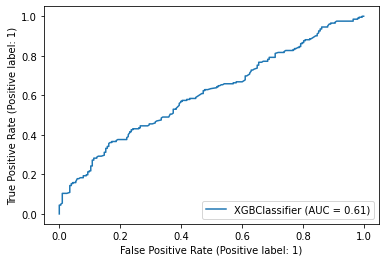

In [150]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_valid,X_valid_without_bureau,y_valid_without_bureau)
plt.show()

In [151]:
y_pred_test_without_bureau = xgb_valid.predict(X_test_without_bureau)
print(classification_report(y_test_without_bureau, y_pred_test_without_bureau))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       289
           1       0.58      0.58      0.58       287

    accuracy                           0.59       576
   macro avg       0.59      0.59      0.59       576
weighted avg       0.59      0.59      0.59       576



In [152]:
print(f"Final DecisionTree Gini Score (on test Set)            : {(2*(roc_auc_score(y_test_without_bureau, xgb_valid.predict_proba(X_test_without_bureau)[:, 1])))-1} ")

Final DecisionTree Gini Score (on test Set)            : 0.2188129197159494 


#### Evaluate with all data

##### Without bureau data

In [153]:
# get all data without bureau
df_all_xb = df[df['LOANS_WITH_DELAYS'].isna() == True]
df_all_xb = df_all_xb.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all_xb.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
1,36500,29,14000000.0,Female,Bachelor Degree,Renovation,19:30:00,Yes,Yes,0,NaN,0.86
2,36505,36,21000000.0,Female,Bachelor Degree,Renovation,06:12:00,No,Yes,1,NaN,0.83
3,36510,44,5000000.0,Male,Bachelor Degree,Investment,17:48:00,No,Yes,1,NaN,0.79
4,36515,34,6000000.0,Male,Bachelor Degree,Credit card,12:17:00,No,Yes,1,NaN,NaN


In [154]:
#test with all data whitout bureau
X_cek,y_cek = feature_engineering_xb(df_all_xb)
X_cek.shape

(1308, 22)

In [155]:
y_pred = xgb_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

ValueError: Feature shape mismatch, expected: 21, got 22

##### Without all data remove bureau

In [156]:
# get all data remove bureau
df_all = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,40000000.0,0.81


In [157]:
X_cek,y_cek = feature_engineering_xb(df_all)
X_cek.shape

(6537, 22)

In [158]:
y_pred = xgb_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

ValueError: Feature shape mismatch, expected: 21, got 22

## all data remove Bureau Data (SMOTE)

In [159]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


In [160]:
# get all data without bureau
df_final = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])

In [161]:
df_final.LOAN_WAS_PAID_BACK.value_counts()

1    5625
0     963
Name: LOAN_WAS_PAID_BACK, dtype: int64

In [162]:
# do the splitting
TARGET = "LOAN_WAS_PAID_BACK"
TEST_SIZE = 0.3

output_df, input_df = split_input_output(
                            df_final,
                            TARGET, save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                                    output_df,
                                                                   True,
                                                                   TEST_SIZE)

In [163]:
# check if stratify is correct
print(y_train.value_counts())
print("-------------------------------------")
print(y_valid.value_counts())
print("-------------------------------------")
print(y_test.value_counts())

1    2755
0     472
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
1    1182
0     202
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
1    1688
0     289
Name: LOAN_WAS_PAID_BACK, dtype: int64


In [164]:
# check if stratify is correct
print(y_train.value_counts(normalize = True))
print("-------------------------------------")
print(y_valid.value_counts(normalize = True))
print("-------------------------------------")
print(y_test.value_counts(normalize = True))

1    0.853734
0    0.146266
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.854046
0    0.145954
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.853819
0    0.146181
Name: LOAN_WAS_PAID_BACK, dtype: float64


In [203]:
x_train.shape

(3227, 11)

### Feature engineering

#### train

In [165]:
df_train = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

In [166]:
# This is our final feature
X_train_without_bureau,y_train_without_bureau = feature_engineering_xb(df_train)

In [167]:
X_train_without_bureau = add_columns_xb(df_final,X_train_without_bureau)

set()


In [168]:
print(f' Data Train Without Bureau has {X_train_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 22 Features


In [169]:
X_train_without_bureau.shape

(3201, 22)

In [170]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

oversample = SMOTE()
X_train_without_bureau, y_train_without_bureau = oversample.fit_resample(X_train_without_bureau, y_train_without_bureau)
X_train_without_bureau.shape

(5460, 22)

In [171]:
print(y_train_without_bureau.value_counts())

1    2730
0    2730
Name: LOAN_WAS_PAID_BACK, dtype: int64


#### Valid

In [172]:
df_valid = pd.concat([x_valid, pd.DataFrame(y_valid)], axis = 1)

In [173]:
# This is our final feature
X_valid_without_bureau,y_valid_without_bureau = feature_engineering_xb(df_valid)

In [174]:
X_valid_without_bureau = add_columns_xb(df_final,X_valid_without_bureau)

set()


In [175]:
print(f' Data Train Without Bureau has {X_valid_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 22 Features


In [176]:
#we try on valid data
X_valid_without_bureau_rs, y_valid_without_bureau_rs = oversample.fit_resample(X_valid_without_bureau, y_valid_without_bureau)
X_valid_without_bureau_rs.shape

(2340, 22)

In [177]:
print(y_valid_without_bureau_rs.value_counts())

1    1170
0    1170
Name: LOAN_WAS_PAID_BACK, dtype: int64


#### Test

In [178]:
df_test = pd.concat([x_test, pd.DataFrame(y_test)], axis = 1)

In [179]:
# This is our final feature
X_test_without_bureau,y_test_without_bureau = feature_engineering_xb(df_test)

In [180]:
X_test_without_bureau = add_columns_xb(df_final,X_test_without_bureau)

{'LOAN_PURPOSE_Car/Motorcycle'}


In [181]:
print(f' Data Train Without Bureau has {X_test_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 22 Features


In [182]:
# Changing everything to float and replacing infinities
for c in X_train_without_bureau.columns:
  X_train_without_bureau[c] = X_train_without_bureau[c].astype(np.float64)
X_train_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [183]:
# Changing everything to float and replacing infinities
for c in X_valid_without_bureau.columns:
  X_valid_without_bureau[c] = X_valid_without_bureau[c].astype(np.float64)
X_valid_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [184]:
# Changing everything to float and replacing infinities
for c in X_test_without_bureau.columns:
  X_test_without_bureau[c] = X_test_without_bureau[c].astype(np.float64)
X_test_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [185]:
# Changing everything to float and replacing infinities
for c in X_valid_without_bureau_rs.columns:
  X_valid_without_bureau_rs[c] = X_valid_without_bureau_rs[c].astype(np.float64)
X_valid_without_bureau_rs.replace([np.inf, -np.inf], np.nan, inplace=True)

In [186]:
X_train_without_bureau.isnull().sum()

AGE                                        0
INCOME                                     0
GENDER                                     0
HAS_APPLIED_BEFORE                         0
HAS_INCOME_VERIFICATION                    0
EDUCATION_Bachelor Degree                  0
EDUCATION_Diploma                          0
EDUCATION_High School                      0
EDUCATION_Master's Degree/Post graduate    0
EDUCATION_Other                            0
LOAN_PURPOSE_Bills                         0
LOAN_PURPOSE_Car/Motorcycle                0
LOAN_PURPOSE_Credit card                   0
LOAN_PURPOSE_Education                     0
LOAN_PURPOSE_Electronic unsecured loan     0
LOAN_PURPOSE_Holiday                       0
LOAN_PURPOSE_Housing loan                  0
LOAN_PURPOSE_Investment                    0
LOAN_PURPOSE_Other                         0
LOAN_PURPOSE_Renovation                    0
LOAN_PURPOSE_Venture capital               0
LOAN_PURPOSE_Working Capital               0
dtype: int

In [187]:
# Fixing column names that contains [,],or < for XGBoost model
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_without_bureau.columns.values]
X_valid_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_without_bureau.columns.values]
X_test_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_without_bureau.columns.values]
X_valid_without_bureau_rs.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_without_bureau_rs.columns.values]

In [188]:
# Check the baseline model
def baseline_model(X_train,y_train):
  clf_logreg = LogisticRegression().fit(X_train,y_train)
  clf_rf = RandomForestClassifier().fit(X_train,y_train)
  clf_tree = DecisionTreeClassifier().fit(X_train,y_train)
  clf_knn = KNeighborsClassifier().fit(X_train,y_train)
  clf_lgbm = LGBMClassifier().fit(X_train,y_train)
  clf_xgb = xgb.XGBClassifier().fit(X_train,y_train)

  gini_logreg = (2*(roc_auc_score(y_train, clf_logreg.predict_proba(X_train)[:, 1])))-1
  gini_rf = (2*(roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:, 1])))-1
  gini_tree = (2*(roc_auc_score(y_train, clf_tree.predict_proba(X_train)[:, 1])))-1
  gini_knn = (2*(roc_auc_score(y_train, clf_knn.predict_proba(X_train)[:, 1])))-1
  gini_lgbm = (2*(roc_auc_score(y_train, clf_lgbm.predict_proba(X_train)[:, 1])))-1
  gini_xgb = (2*(roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1])))-1

  print("Gini Performance Evaluation\n")
  print(f"Logistic Regression Gini : {gini_logreg}")
  print(f"Random Forest Gini       : {gini_rf}")
  print(f"Decision Tree Gini       : {gini_tree}")
  print(f"KNN Classifier Gini      : {gini_knn}")
  print(f"LGBM Gini                : {gini_lgbm}")
  print(f"XGBoost Gini             : {gini_xgb}")

  return clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb
 
clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb = baseline_model(X_train_without_bureau,y_train_without_bureau)

Gini Performance Evaluation

Logistic Regression Gini : 0.3822611332501442
Random Forest Gini       : 0.8742908129721316
Decision Tree Gini       : 0.8801119027492654
KNN Classifier Gini      : 0.7426636611251998
LGBM Gini                : 0.8231970105596478
XGBoost Gini             : 0.8394909364140133


Hyperparameter tuning on best baseline model
We will be using Decision Tree since it has the highest gini score.

#### Hyperparameter tuning on best baseline model


In [189]:
%%time

clf_xgb = xgb.XGBClassifier()
clf_tree = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=420)

# Define search space
space_tree = dict()
space_rf = dict()
space_xgb = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
    'fs__k': [10],
  }
]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #RF
max_depth.append(None) #RF
space_rf['max_depth'] = max_depth # RF
space_rf['min_samples_split'] = [2, 5, 10] # RF
space_rf['min_samples_leaf'] = [1, 2, 4] # RF

space_tree['max_depth'] = [2, 3, 5, 10, 20] #DT
space_tree['min_samples_leaf'] = [5, 10, 20, 50, 100] #DT
space_tree['criterion'] = ["gini", "entropy"] #DT

# Define search
search_tree = RandomizedSearchCV(clf_tree, space_tree, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_rf = RandomizedSearchCV(clf_rf, space_rf, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_xgb = RandomizedSearchCV(clf_xgb, space_xgb, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)

# Execute search
result_tree = search_tree.fit(X_train_without_bureau,y_train_without_bureau)
result_rf = search_rf.fit(X_train_without_bureau,y_train_without_bureau)
result_xgb = search_xgb.fit(X_train_without_bureau,y_train_without_bureau)

# Summarize result
print('Best Score tree: %s' % ((result_tree.best_score_ * 2) - 1))
print('Best Hyperparameters: %s' % result_tree.best_params_)

print('Best Score rf: %s' % ((result_rf.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_rf.best_params_)

print('Best Score xgb: %s' % ((result_xgb.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_xgb.best_params_)

Best Score tree: 0.6741697862576985
Best Hyperparameters: {'min_samples_leaf': 5, 'max_depth': 20, 'criterion': 'entropy'}
Best Score rf: 0.7418380764534611
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}
Best Score xgb: 0.7561975875162688
Best Hyperparameters: {'fs__k': 10, 'clf__n_estimators': 200, 'clf__max_depth': 8, 'clf__learning_rate': 0.3, 'clf__gamma': 0.0, 'clf__colsample_bytree': 0.1}
Wall time: 2min 39s


#### Evaluate on validation data

In [190]:
dt_valid = DecisionTreeClassifier(
    min_samples_leaf = 5, 
    max_depth = 20, 
    criterion = 'entropy').fit(X_train_without_bureau,y_train_without_bureau)

rf_valid = RandomForestClassifier(
    min_samples_split = 5, 
    min_samples_leaf = 1, 
    max_depth = None).fit(X_train_without_bureau,y_train_without_bureau)

xgb_valid = xgb.XGBClassifier(
    fs__k= 10, 
    n_estimators= 200, 
    max_depth= 8, 
    learning_rate= 0.3, 
    gamma= 0.0, 
    colsample_bytree= 0.1,
    verbosity = 0).fit(X_train_without_bureau,y_train_without_bureau)

def gini_value(x, y, model):
    return (2*(roc_auc_score(y, model.predict_proba(x)[:, 1])))-1

print("GINI validation data for Decision Tree :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, dt_valid))
print("GINI validation data for Random Forest :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, rf_valid))
print("GINI validation data for XGBOOST :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, xgb_valid))

GINI validation data for Decision Tree : 0.1356295445847684
GINI validation data for Random Forest : 0.12013437088063972
GINI validation data for XGBOOST : 0.2041161712803503


In [191]:
from sklearn.metrics import classification_report

y_pred_train = xgb_valid.predict(X_train_without_bureau)

print(classification_report(y_train_without_bureau, y_pred_train))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      2730
           1       0.73      0.80      0.77      2730

    accuracy                           0.76      5460
   macro avg       0.76      0.76      0.76      5460
weighted avg       0.76      0.76      0.76      5460



In [192]:
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_without_bureau)

print(classification_report(y_valid_without_bureau, y_pred_valid))

              precision    recall  f1-score   support

           0       0.21      0.34      0.26       201
           1       0.87      0.78      0.82      1170

    accuracy                           0.72      1371
   macro avg       0.54      0.56      0.54      1371
weighted avg       0.78      0.72      0.74      1371



In [193]:
#dengan data validation yang sudah di resample
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_without_bureau_rs)

print(classification_report(y_valid_without_bureau_rs, y_pred_valid))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1170
           1       0.75      0.78      0.76      1170

    accuracy                           0.76      2340
   macro avg       0.76      0.76      0.76      2340
weighted avg       0.76      0.76      0.76      2340



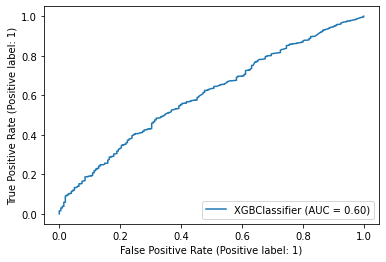

In [194]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_valid,X_valid_without_bureau,y_valid_without_bureau)
plt.show()

In [195]:
y_pred_test_without_bureau = xgb_valid.predict(X_test_without_bureau)
print(classification_report(y_test_without_bureau, y_pred_test_without_bureau))

              precision    recall  f1-score   support

           0       0.17      0.09      0.11       289
           1       0.85      0.93      0.89      1676

    accuracy                           0.80      1965
   macro avg       0.51      0.51      0.50      1965
weighted avg       0.75      0.80      0.77      1965



In [196]:
print(f"Final DecisionTree Gini Score (on test Set)            : {(2*(roc_auc_score(y_test_without_bureau, xgb_valid.predict_proba(X_test_without_bureau)[:, 1])))-1} ")

Final DecisionTree Gini Score (on test Set)            : -0.0369598070872319 


#### Evaluate with all data

##### Without bureau data

In [197]:
# get all data without bureau
df_all_xb = df[df['LOANS_WITH_DELAYS'].isna() == True]
df_all_xb = df_all_xb.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all_xb.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
1,36500,29,14000000.0,Female,Bachelor Degree,Renovation,19:30:00,Yes,Yes,0,NaN,0.86
2,36505,36,21000000.0,Female,Bachelor Degree,Renovation,06:12:00,No,Yes,1,NaN,0.83
3,36510,44,5000000.0,Male,Bachelor Degree,Investment,17:48:00,No,Yes,1,NaN,0.79
4,36515,34,6000000.0,Male,Bachelor Degree,Credit card,12:17:00,No,Yes,1,NaN,NaN


In [198]:
#test with all data whitout bureau
X_cek,y_cek = feature_engineering_xb(df_all_xb)
X_cek.shape

(1308, 22)

In [199]:
y_pred = xgb_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.30      0.24       202
           1       0.86      0.79      0.82      1106

    accuracy                           0.71      1308
   macro avg       0.53      0.54      0.53      1308
weighted avg       0.76      0.71      0.73      1308



##### Without all data remove bureau

In [200]:
# get all data remove bureau
df_all = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"]).reset_index(drop=True)
df_all.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,40000000.0,0.81


In [201]:
X_cek,y_cek = feature_engineering_xb(df_all)
X_cek.shape

(6537, 22)

In [202]:
y_pred = xgb_valid.predict(X_cek)
print(classification_report(y_cek, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.34      0.27       961
           1       0.88      0.80      0.83      5576

    accuracy                           0.73      6537
   macro avg       0.55      0.57      0.55      6537
weighted avg       0.78      0.73      0.75      6537



In [209]:
d = {"a" : 1, "b":2, "c" : {"xx" : 3, "yy" : 4}}

In [217]:
t = pd.json_normalize(d, sep='_')
t.rename()

In [221]:
dict(zip(list(t.columns), [1,2,3,4]))

{'a': 1, 'b': 2, 'c_xx': 3, 'c_yy': 4}